<a href="https://colab.research.google.com/github/pinballsurgeon/deluxo_adjacency/blob/main/wound_care_emergence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

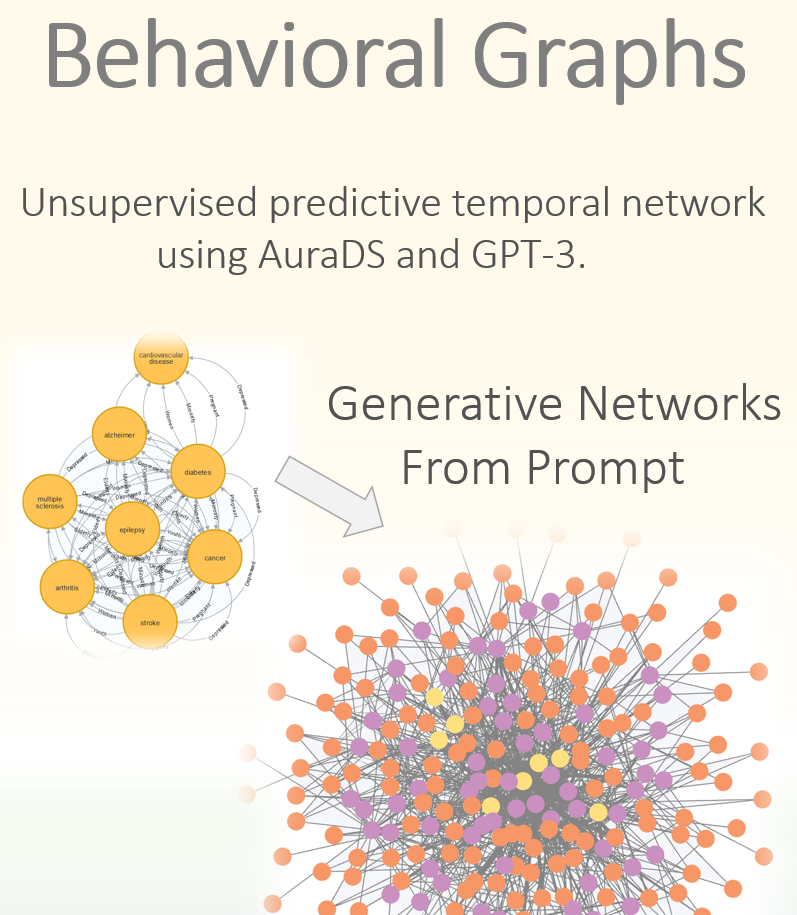

##Unsupervised, Generative Behavioral Graphs
  Produce enormous graph networks, based on time-series correlation between topics
  1.  Get an OpenAi token, save to a file and import, ex. 'openai_key'
  2.  Input list of seed topics that you want expanded upon
  3.  Experiment with new variations in OpenAi questioning format

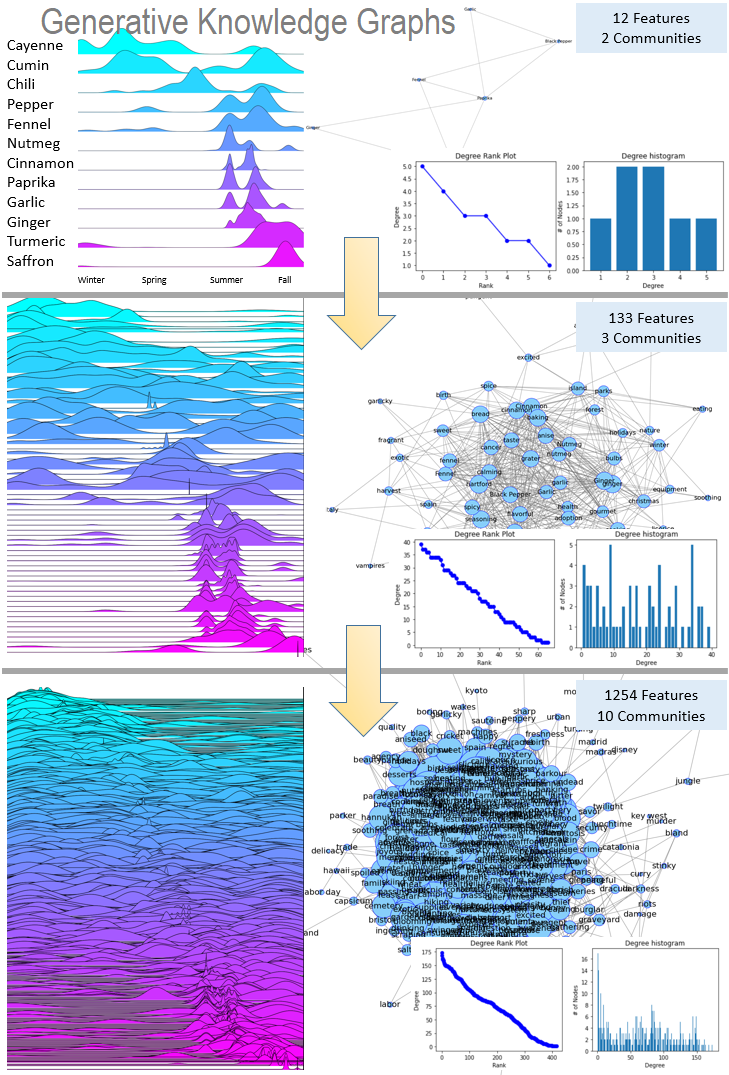

## installs

In [ ]:
!pip install pytrends
!pip install joypy

# install openai
!pip install openai

# install dgl
!pip install dgl

# jupyter viz
!pip install visJS2jupyter

# install transformers
!pip install transformers -q

# install neo4j gds
!pip install graphdatascience

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## imports

In [ ]:
import numpy
import pandas 
import re
import string
import os

import time 
from difflib import SequenceMatcher

from pytrends.request import TrendReq
from pytrends         import dailydata
import pytrends
from operator         import index

import joypy
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn 
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import openai

import networkx as nx
from networkx.algorithms.community.modularity_max import greedy_modularity_communities

import dgl
import dgl.function as fn
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph
import visJS2jupyter.visualizations as visualizations

# supply openai api key via file 
openai.api_key = open('openai_key').read()
#openai.api_key = 'rrtt'

# LM transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, set_seed

# pytorch
import torch
torch.set_default_tensor_type(torch.cuda.FloatTensor)

import gc
gc.collect

# graph data science - neo4j
from graphdatascience import GraphDataScience 
from neo4j import GraphDatabase

# import BLOOM models
# model = AutoModelForCausalLM.from_pretrained("bigscience/bloom-1b3", use_cache=True)
# tokenizer = AutoTokenizer.from_pretrained("bigscience/bloom-1b3")

# model = AutoModelForCausalLM.from_pretrained("bigscience/bloom-350m", use_cache=True)
# tokenizer = AutoTokenizer.from_pretrained("bigscience/bloom-350m")


In [ ]:
# neo4j aurads connection
AURA_CONNECTION_URI = "neo4j+s://6e96e772.databases.neo4j.io"
AURA_USERNAME = "neo4j"
AURA_PASSWORD = open('neo4j_key.txt').read()

# Client instantiation
gds = GraphDataScience(
    AURA_CONNECTION_URI,
    auth=(AURA_USERNAME, AURA_PASSWORD),
    aura_ds=True
)

# confirm connection
print(gds.version())

2.1.9


## seed config

In [ ]:
### Generative Seeds, topics and question formatting to feed to OpenAi

# dispaly neo4j cypher commands for learning and debug
cypher_echo = True

# within list of strings, declare topics to be fit to behaviors
topics = ['diabetes', 'cardiovascular disease', 'pressure ulcers'
         , 'multiple sclerosis', 'stroke', 'epilepsy '
         ,'arthritis', 'cancer', 'alzheimer']

context = ['elderly', 'diabetic', 'pregnant', 'man', 'women']

perspective = ['texas', 'california', 'new york', 'mid west', 'south', 'florida']


# manual run
manual_context = 'Minority'
manual_state = 'New York'
manual_state_merge = 'newyork'
manual_state_trend = 'NY'


# general regex cleaning prescription
regex = re.compile('[^a-zA-Z ]')


# connection strenth minimum boost, base on standard deviation
std_factor = .2
std_factor = 0
pop_threshold = 0

# batch size
batch_size = 30

# max fetch
max_fetch = 120

# max relationship strength
max_similarity = 0.95

## helper functions
  1. get_trend_frame(topics, years): 
          returns a dataframe of topic trends
  2. stack_nodes_vertically(df_features): 
          form graph source/target relationships
  3. build_node_labels(df_flat): 
          generate labels based on time interval
  4. get_ridgeplot(df_flat):
          visualize temporal attributes
  5. get_openai_response(question):
          using standard format, prompt openai for new top lists
  6. get_pairwise_similarity(df_features, topics, std_factor): 
          for combinations of topics, get temporal correlation
  7. swap_tokens(chk_topics, new_topics):
          replace any duplicates between existing and new features
  8. build_graph_network(df_slice):
          buiod graph
  9. get_openai_generated_topics(topic, obj):
          form openAi question given generative seeds
  10. get_related_topics(df):
          mechanism for enhancing graph based on generative seeds
  11. get_graph_degree(G):
          get graph statisitcs for feeding into downstream predictive models

In [ ]:
### 1. for a given list of topics, return dataframe of interests from pytrend
def get_trend_frame(topics, years, state_code):

  # batch management
  batch_counter = 0
  batch_idx = 0
  fetch_idx = 0

  # initialize return frame
  df_total = pandas.DataFrame()

  # for each provided TOPIC
  for topic in topics:

    if fetch_idx > max_fetch:
      print('hit local max of %d' % (fetch_idx))
      break

    # prevent saturation of api endpoint
    if batch_counter > batch_size:
      print('')
      batch_idx+=1
      print('completed retrieval of batch %d - %d rows of %d' % (batch_idx, round(batch_idx * batch_size), len(topics) ))
      batch_counter=0
      time.sleep(30)


    # pytrend request
    pytrend = TrendReq()
    pytrend.build_payload(kw_list=[topic]
                         ,geo=( "US-%s" % (state_code) )
                         ,timeframe=( 'today %s-y' % (years)))
    
    # load trend request
    df = pytrend.interest_over_time()

    # counters
    batch_counter+=1
    fetch_idx+=1

    try:

      # add column for new topic
      df_total[topic] = df[topic]


    except:
      print('failed to add topic - %s ' % (topic))


  # drop nans
  df_total = df_total.dropna()

  # return standard frame
  return df_total

In [ ]:
### 2. for each topic and interval of time, stack a vertical dataframe of value counts
def stack_nodes_vertically(df_features):

  # initialize buffers resources
  df_stk=pandas.DataFrame()
  globalst=[]

  # for each feature
  for col in df_features:                      # topic

      # for each time interval
      for val in df_features.index.weekofyear: # weeknum

          try:

            # time sensitive
            fs_val = df_features[col][val]       # full spectrum
                
            if fs_val > pop_threshold:

              # iterate through each instance of max bin occurence, determining number of weeks written
              for x in range(0,int(abs(fs_val) * 100)):
                
                  # build buffer list
                  lst = [val, val, col]
                  globalst.append(lst)

            else:
                  # build buffer list
                  lst = [val, None, None]
                  globalst.append(lst)

          except Exception as e: # work on python 3.x
              print(col)              
              print(val)
              print(fs_val)
              print('Failed to upload to ftp: '+ str(e))

  # materialize vertically flattened
  df_flat = pandas.DataFrame(globalst
                            ,columns=['WeekNum'
                            ,'WeekNum_Rct'
                            ,'Flower_Tot'])
  
  return df_flat

In [ ]:
### 3. prefix ridgemap/joyplot labels with weeknum average
def build_node_labels(df_flat):
  
  # get all distinct nodes
  df_stats = df_flat.groupby('Flower_Tot').agg(['mean', 'count']).reset_index()

  # rename columns to node labels
  df_stats.columns = [' '.join(col).strip() for col in df_stats.columns.values]

  # sort by average time interval
  df_stats = df_stats.sort_values(by='WeekNum mean',ascending=True)

  # include average into node label
  df_stats['Name'] = ( ( df_stats['WeekNum mean'] * 100) + 1000).astype('int').astype('str') + ' '+ df_stats['Flower_Tot']

  # update flattened node space with averaged names
  for index, row in df_stats.iterrows():
      df_flat['Flower_Tot'] = df_flat['Flower_Tot'].replace(row['Flower_Tot'], row['Name'])

  return df_flat

In [ ]:
### 4. display ridgeplot of time frame, for 
def get_ridgeplot(df_flat):


  # colors = ["lightgray", "lightgreen", "yellowgreen", "lightgreen", "lightgray"]
  # colors = ["white", "lightgray", "lightgreen", "lightgray", "white"]
  colors = ["white", "#6DC14C", "white"]  
  cmap1 = LinearSegmentedColormap.from_list("mycmap", colors)

  # configure and build ridgeplot
  fig, axes = joypy.joyplot(df_flat
                            , column=['WeekNum', 'WeekNum_Rct']
                            , by='Flower_Tot'
                            , overlap=1.2
                            , fill=True
                            , figsize=(22,22)
                            , x_range = [0,52]
                            , colormap=cmap1
                            # , colormap=cm.YlGn                         
                            , ylim='own'
                          )


  # write ridgeplot
  # plt.savefig(('/content/drive/MyDrive/frank_jj_%s.png' % (len(df_flat))) )
  # plt.savefig(my_path + '/Sub Directory/graph.png')


  # plot
  plt.show()

In [ ]:
### 5. send openai question, receive response
def get_openai_response(question):

    # format open au request
    response = openai.Completion.create(
                      engine="text-davinci-001",
                      prompt=question,
                      temperature=.5,
                      max_tokens=250,
                      top_p=1,
                      frequency_penalty=50,
                      presence_penalty=0 )

    # parse and process open ai response
    response_choices = response["choices"]

    # replace blanks
    response = response_choices[0]["text"].strip('\n')

    return response

In [ ]:
def swap_tokens(chk_topics, new_topics):

  buffer_lst = []

# for each graphed topics
  for chk_topic in chk_topics:

    buffer_lst.append(chk_topic)


  for new_topic in new_topics:

    # token validation checks

      new_topic_split = new_topic.split()
    
    # 1. check that not preceeded by short word
      if len(new_topic_split[0]) < 3:

        try:
          new_topic = new_topic_split[1]
        except:
          pass
        

      buffer_lst.append(new_topic)


  return buffer_lst


In [ ]:
def get_pairwise_similarity(df_features, topics, std_factor):

  # pair wise correlation / similarity
  c = df_features.corr().abs()

  # flatten and sort
  so = c.unstack().sort_values(kind="quicksort")

  # remove low connections
  min_connection_strength = so.mean() + ( std_factor * so.std() )
  min_connection_cutoff = len(so) - len(so[so > min_connection_strength])

  # turn to frame
  df_slice = so[min_connection_cutoff:-len(topics)].to_frame()

  df_slice.reset_index(inplace=True)

  df_slice.columns = ['source','target','weight']

  return df_slice

In [ ]:
def build_graph_network(df_slice):

  # build graph 
  G = nx.from_pandas_edgelist(df_slice
                            ,'source'          # parent
                            ,'target'          # child
                            , ['weight'])      # relationship


  # define plot area
  plt.figure(3,figsize=(22,22)) 

  # calc degrees per node
  d = dict(G.degree)

  # visualize graph 
  nx.draw(G         
      ,nx.kamada_kawai_layout(G)               
      ,with_labels=True
      ,edge_color='gray'
      ,node_color='#6DC14C'
      ,node_size=[v * 700 for v in d.values()]
      ,font_size=22)
  
  ax = plt.gca() # to get the current axis
  ax.collections[0].set_edgecolor("blue")

  return G

In [ ]:
def get_related_topics(df, context, perspective):

  lst_buffer = []
  graph_topics = list(df['source'].unique())

  # batch management
  batch_counter = 0
  batch_idx = 0
  fetch_idx = 0

  # TOPICS
  for graph_topic in graph_topics:

    # if match is hit
    if fetch_idx > max_fetch:
      print('hit local max of %d' % (fetch_idx))
      break

    # RELATIVE ITERATOR 
    for obj in relatives:

      # prevent saturation of api endpoint
      if batch_counter > batch_size:
        print('')
        batch_idx+=1
        print('completed openai retrieval of batch %d - %d rows of %d' % 
              (batch_idx, round(batch_idx * batch_size)
              , len(graph_topics) * len(relatives) ))
        batch_counter=0
        time.sleep(30)

      topic_list = get_openai_generated_topics(graph_topic, obj, perspective)

      print(topic_list)

      for topic in topic_list:

        topic = topic.translate(string.punctuation)
        topic = re.sub(r'[^\w\s]','',topic)

        if len(topic) < 10 and len(topic) > 4:

          lst_buffer.append(topic)
        fetch_idx+=1
      
      # counters
      batch_counter+=1
      
      print(lst_buffer)
    
  return lst_buffer

In [ ]:
def get_graph_degree(G):
  degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
  dmax = max(degree_sequence)

  fig = plt.figure("Degree of a random graph", figsize=(8, 8))
  # Create a gridspec for adding subplots of different sizes
  axgrid = fig.add_gridspec(5, 4)

  ax0 = fig.add_subplot(axgrid[0:3, :])
  Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
  pos = nx.spring_layout(Gcc, seed=10396953)
  nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
  nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
  ax0.set_title("Connected components of G")
  ax0.set_axis_off()

  ax1 = fig.add_subplot(axgrid[3:, :2])
  ax1.plot(degree_sequence, "b-", marker="o")
  ax1.set_title("Degree Rank Plot")
  ax1.set_ylabel("Degree")
  ax1.set_xlabel("Rank")

  ax2 = fig.add_subplot(axgrid[3:, 2:])
  ax2.bar(*numpy.unique(degree_sequence, return_counts=True))
  ax2.set_title("Degree histogram")
  ax2.set_xlabel("Degree")
  ax2.set_ylabel("# of Nodes")

  fig.tight_layout()
  plt.show()

In [ ]:
### BLOOM - Generate Bloom response model
def get_bloom_response(question):

  # response = model.generate(**question
  #                         , num_beams = 2
  #                         , num_beam_groups = 2
  #                         , top_k=1
  #                         , temperature=0.9
  #                         , repetition_penalty = 2.0
  #                         , diversity_penalty=2.0
  #                         , max_new_tokens = 20)
  
  response = model.generate(**question
                          , max_length = 100
                          , repetition_penalty = 2.0
                          , top_k = 0
                          , temperature=0.9)  
  
  print(response)
  
  return response



In [ ]:
### BLOOM - Form request
def prompt_bloom(question):

  # initiate tokenizer
  input_tokens = tokenizer(question, return_tensors="pt").to(0)

  # build sentence and retrieve 
  retrieval = get_bloom_response(input_tokens)

  # decode retrieval
  retrieval = tokenizer.decode(retrieval[0], truncate_before_pattern=[r"\n\n^#", "^'''","\n\n\n"])

  print(retrieval)

  # remove prompt from response
  retrieval = retrieval.replace(question, '')

  # replace blanks
  retrieval = retrieval.strip()
  
  # replace non-alphabet chars
  retrieval = regex.sub('', retrieval)

  return retrieval

In [ ]:
### 
# topic = 
# obj = relative
# state = perspective
def get_openai_generated_topics(topic, obj, state):
  
  new_tokens_list = []

  responses = []

  # question = 'from the perspetive of a %s resident, list several %s topics linked to %s' % ( state , obj , topic )
  question = 'from the perspetive of %s resident, list single words %s topics linked to %s' % ( state , obj , topic )

  # retrieve 
  retrieval = get_openai_response('from the perspetive of %s resident, list single words %s topics linked to %s' % ( state , obj , topic ))

  print(question)

  # retrieval = get_openai_response('list one word %s related to %s' % (obj , topic))
  responses.append(retrieval)

  print(responses)

  new_tokens = re.split("; |, |\*|\n",responses[0].lower())

  return new_tokens

In [ ]:
# neo4j connection class
class Neo4jConnection:
    
    def __init__(self, uri, user, pwd):
        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None
        try:
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd))
        except Exception as e:
            print("Failed to create the driver:", e)
        
    def close(self):
        if self.__driver is not None:
            self.__driver.close()
        
    def query(self, query, parameters=None, db=None):
        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None
        try: 
            session = self.__driver.session(database=db) if db is not None else self.__driver.session() 
            response = list(session.run(query, parameters))
        except Exception as e:
            print("Query failed:", e)
        finally: 
            if session is not None:
                session.close()
        return response


conn = Neo4jConnection(uri=AURA_CONNECTION_URI, 
                       user=AURA_USERNAME,              
                       pwd=AURA_PASSWORD)

In [ ]:
def insert_data(query, rows, batch_size = 10000):

    # Function to handle the updating the Neo4j database in batch mode.
    total = 0
    batch = 0
    start = time.time()
    result = None
    
    # return cypher query for learning opportunity
    if cypher_echo:
      print(query)
    
    # batch processing
    while batch * batch_size < len(rows):

        res = conn.query(query, 
                         parameters = {'rows': rows[batch*batch_size:(batch+1)*batch_size].to_dict('records')})
        
        total += res[0]['total']
        batch += 1
        result = {"total":total, 
                  "batches":batch, 
                  "time":time.time()-start}
        
    return result

In [ ]:
def add_nodes(categories, node_label, node_type):
    # Adds category nodes to the Neo4j graph.
    query = '''
            UNWIND $rows AS row
            MERGE (c:''' + node_type + ''' {''' + node_type + ''': row.''' + node_label + '''})
            RETURN count(*) as total
            '''
    return conn.query(query, parameters = {'rows':categories.to_dict('records')})

In [ ]:
def add_edges(rows, left_node, right_node, left_node_label, right_node_label):

   query = '''
   UNWIND $rows as row
   MATCH (p:''' + left_node_label + ''' {''' + left_node_label + ''':row.''' + left_node + '''}) 
 
   WITH row, p

    UNWIND row.''' + right_node + ''' AS right_value
    MATCH (c:''' + right_node_label + ''' {''' + right_node_label + ''': right_value})
    MERGE (p)-[r:''' + manual_context + ''']->(c)
    SET r.''' + manual_state_merge + ''' = row.weight
    RETURN count(distinct p) as total
   '''
 
   print(query)

   return insert_data(query, rows)

In [ ]:
def write_node(df_slice, label_col, node_label):

  # create dataframe
  categories = pandas.DataFrame(df_slice[label_col])
  categories.rename(columns={label_col:label_col},
                    inplace=True)

  # prep distinct nodes
  categories = categories.explode(label_col) \
                        .drop_duplicates(subset=[label_col])

  # write nodes
  add_nodes(categories, label_col, node_label)

In [ ]:
def create_node_property(new_property, label):
  q1='''MATCH (n)-[p]-() 
  WHERE p.''' + label + ''' is not null
  WITH n, count(distinct p) as calculated
  SET n.''' + new_property + ''' = calculated / 2
  RETURN n, calculated'''
  nodes = conn.query(q1)

  q1='''MATCH (n)-[p]-() 
  WHERE p.''' + label + ''' is null
  SET n.''' + new_property + ''' = 0
  RETURN n'''
  nodes = conn.query(q1)

In [ ]:
def build_node_reference():

  # query aurads
  q1="MATCH (n) return ID(n), LABELS(n), PROPERTIES(n)"
  nodes = conn.query(q1)

  # node buffer
  node_map = {}

  # for each returned node
  for row in nodes:
    row_rec_idx = 0
    row_rec_chk = 0
    
    # for each item in row record
    for prop in row:

      # record nodes id
      if row_rec_idx == 0:
        node_id = prop
        row_rec_chk += 1

      # record node label
      if row_rec_idx == 1:
        node_label = prop[0]
        row_rec_chk += 1

      # record node name
      if row_rec_idx == 2:
        node_name = list(prop.values())[0]
        row_rec_chk += 1


      if row_rec_chk ==3:
        node_map[node_id] = [node_name, node_label]


      row_rec_idx += 1

  # build label map
  label_map = {}
  for i in node_map:
    label_map[node_map[i][0]] = node_map[i][1]
  
  return node_map, label_map

In [ ]:
def project_per_node_property(node_property):
  try:

    # check if requested graph exists, delete if so
    if gds.graph.exists('myGraph_2')[1]:
      G = gds.graph.get('myGraph_2')
    gds.graph.drop(G)

  except:
    print('failure in graph initiation')

  G, _ = gds.graph.project('myGraph_2',{  
      'prompt': {
      'properties': [node_property]}
    ,'generated_wave_1': {
      'properties': [node_property]}
    ,'generated_wave_2': {
      'properties': [node_property]}    
      }
  , ['*'] )

  return G

In [ ]:
def create_pipeline(name):
  # check if requested graph exists, delete if so
  if gds.beta.pipeline.exists(name)[2] == True:
    pl = gds.pipeline.get(name)
    gds.beta.pipeline.drop(pl)

  pipe, _ = gds.beta.pipeline.nodeClassification.create(name)

  return pipe

In [ ]:
def projection_embedding(pipe, node_property_name):
  pipe.addNodeProperty('fastRP', mutateProperty=node_property_name, embeddingDimension=256)

  return pipe

In [ ]:
def create_model(G, name, target):
  # check if requested graph exists, delete if so
  if gds.beta.model.exists(name)[2] == True:
    md = gds.model.get(name)
    gds.beta.model.drop(md)

  trained_pipe_model, res = pipe.train(G, modelName="my-model"
                                     , nodeLabels=['prompt','generated_wave_1','generated_wave_2']
                                     , targetProperty=target
                                     , metrics=['F1_WEIGHTED', 'OUT_OF_BAG_ERROR', 'ACCURACY'])

  return trained_pipe_model, res

In [ ]:

def shortest_path(source_node, target_node):
  source_id = gds.find_node_id([label_map[source_node]], {label_map[source_node]: source_node})
  target_id = gds.find_node_id([label_map[target_node]], {label_map[target_node]: target_node})

  res = gds.shortestPath.dijkstra.stream(G, sourceNode=source_id, targetNode=target_id)

  nodes_ids = res.nodeIds

  for nodes in nodes_ids:

    for node in nodes:

      print(node_map[node][0])

In [ ]:
def graph_stats(source_node, target_node):

  source_id = gds.find_node_id([label_map[source_node]], {label_map[source_node]: source_node})
  target_id = gds.find_node_id([label_map[target_node]], {label_map[target_node]: target_node})

  # adamicAdar link prediction
  score = gds.alpha.linkprediction.adamicAdar(source_id, target_id)

  print('adamicAdar link prediction - %f' % (score))


  # total neighbors between to items
  score = gds.alpha.linkprediction.totalNeighbors(source_id, target_id)

  print('total neighbors - %f' % (score))


  # common neighbors between to items
  score = gds.alpha.linkprediction.commonNeighbors(source_id, target_id)

  print('common neighbors - %f' % (score))

  # same community between to items
  score = gds.alpha.linkprediction.sameCommunity(source_id, target_id)

  print('number of nodes in same commnuity - %f' % (score))

  # same community between to items
  # gds.
  # score = gds.alpha.nodeSimilarity(source_id, target_id)

  print('number of nodes in same commnuity - %f' % (score))


## Start Buffer

In [ ]:
# node label buffer
node_labels = {}

# Generative Topics

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  if sys.path[0] == '':


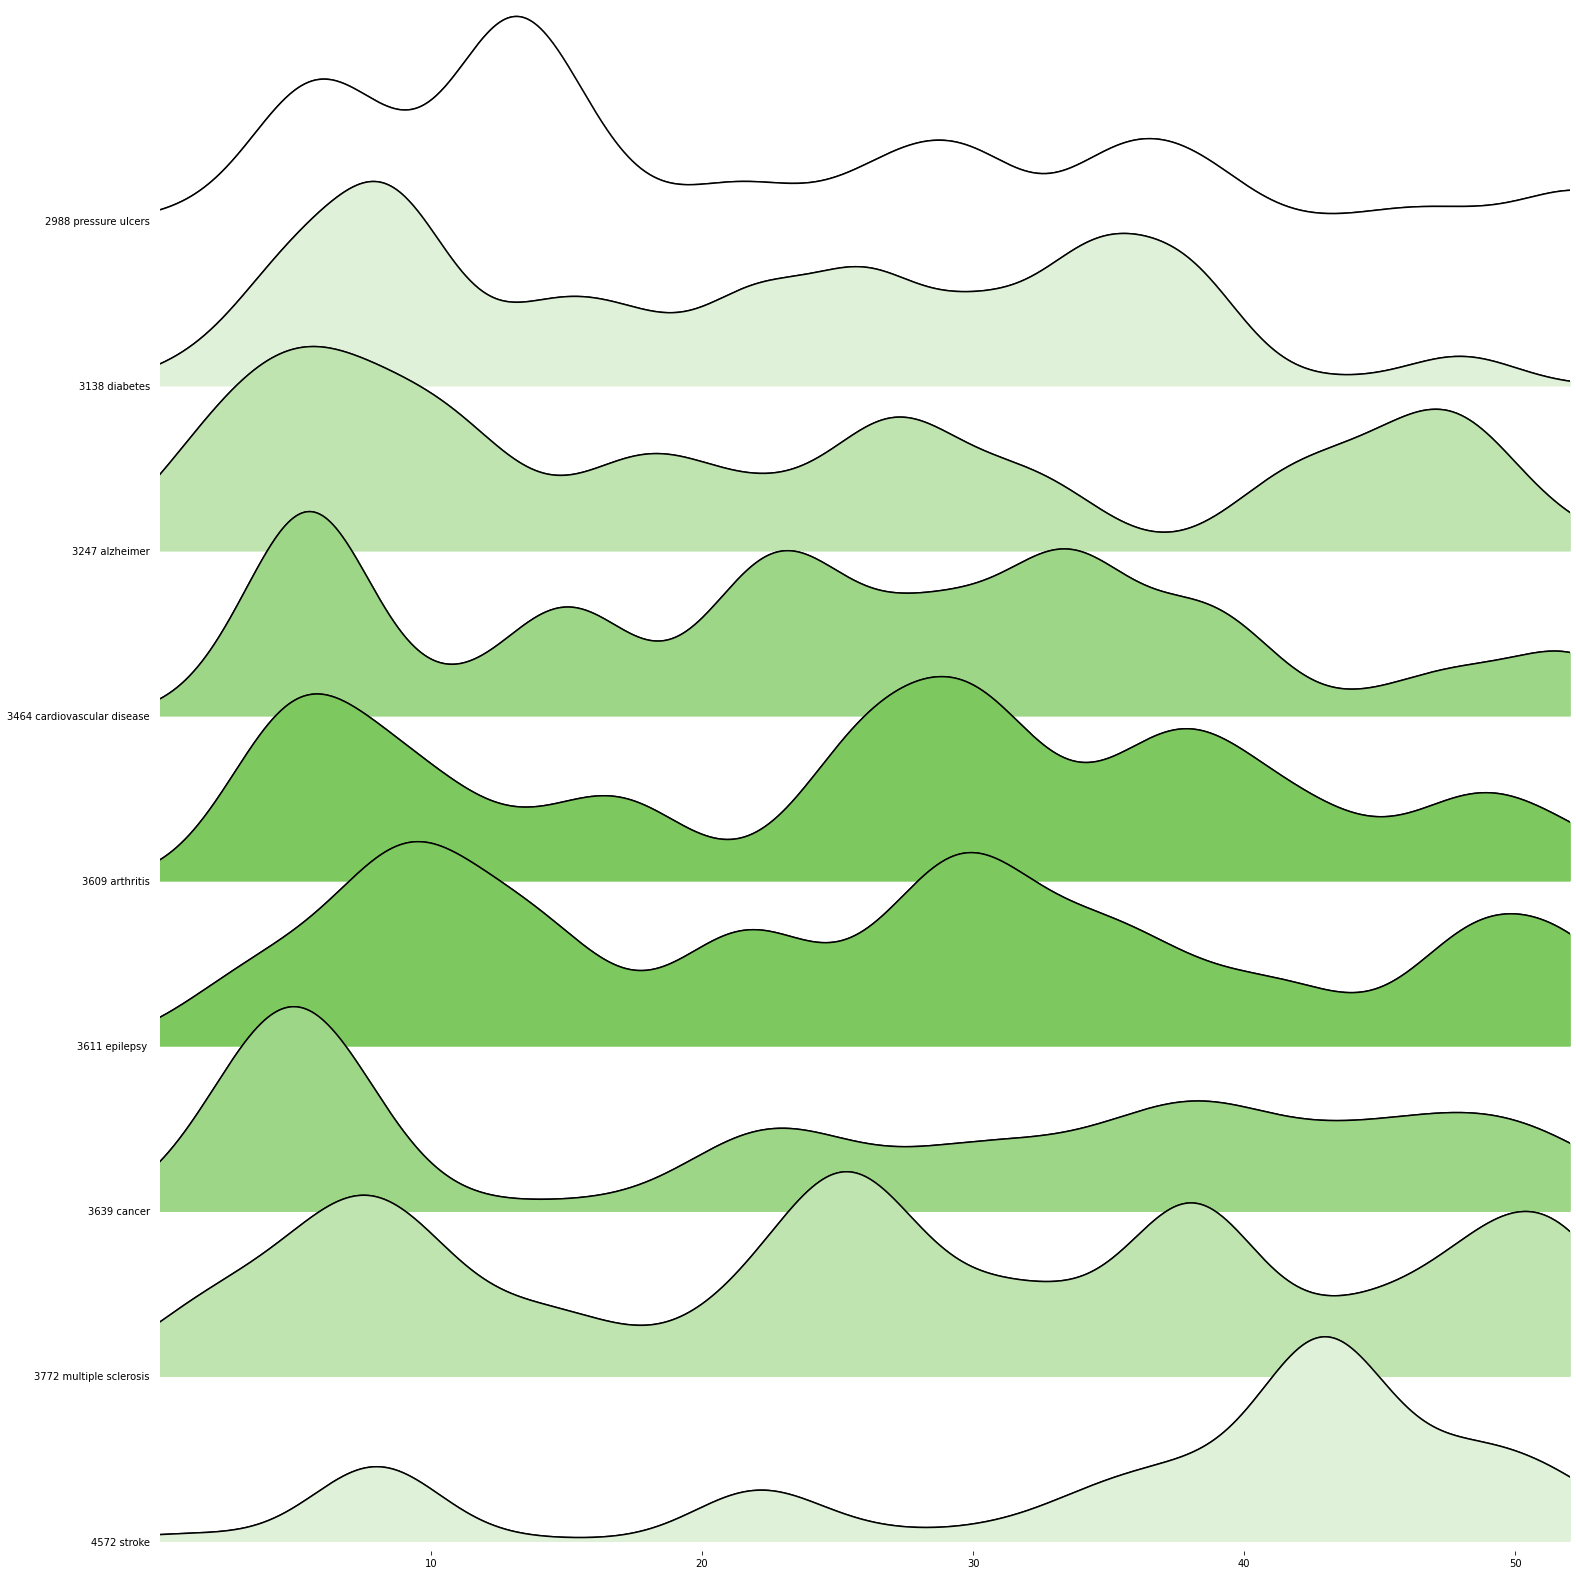

In [ ]:
# request features
df_features = get_trend_frame(topics, '5', manual_state_trend)

# normalize feature space
df_features=(df_features-df_features.mean())/df_features.std()

# flatten feature space vertically
df_flat = stack_nodes_vertically(df_features)

# build node labels
df_flat = build_node_labels(df_flat)

# display ridgeplot of events

get_ridgeplot(df_flat)


   UNWIND $rows as row
   MATCH (p:prompt {prompt:row.source}) 
 
   WITH row, p

    UNWIND row.target AS right_value
    MATCH (c:prompt {prompt: right_value})
    MERGE (p)-[r:Minority]->(c)
    SET r.newyork = row.weight
    RETURN count(distinct p) as total
   

   UNWIND $rows as row
   MATCH (p:prompt {prompt:row.source}) 
 
   WITH row, p

    UNWIND row.target AS right_value
    MATCH (c:prompt {prompt: right_value})
    MERGE (p)-[r:Minority]->(c)
    SET r.newyork = row.weight
    RETURN count(distinct p) as total
   


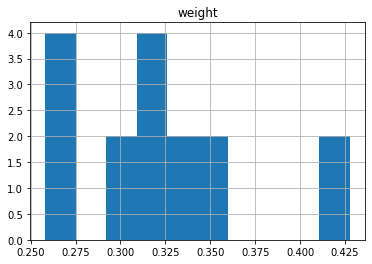

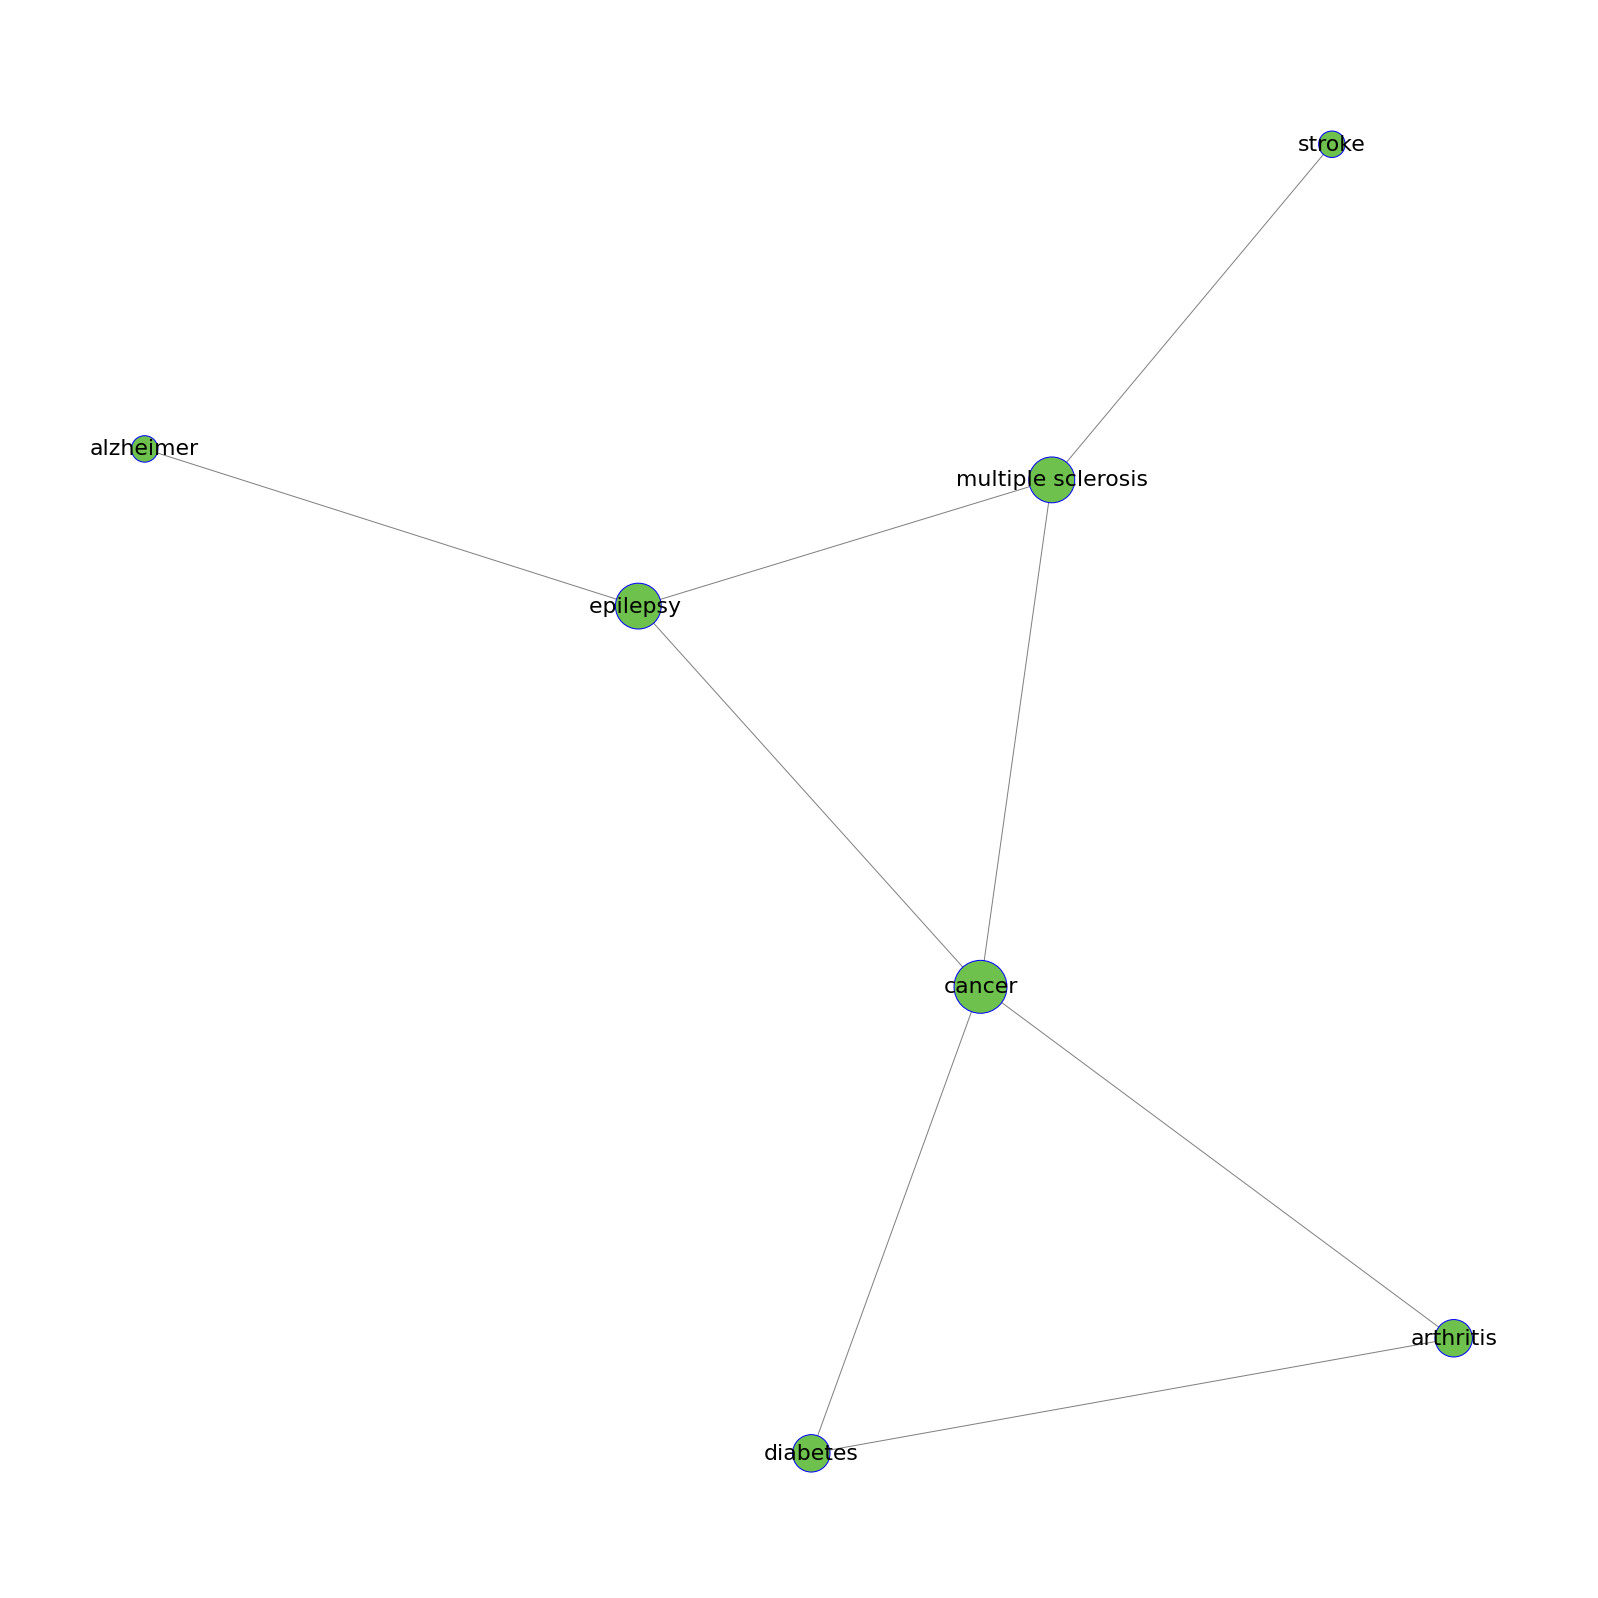

In [ ]:
# ensure single way relationships
edge_track = {}

## time-based pairwise similiarity weights
df_slice = get_pairwise_similarity(df_features, topics, std_factor)

# display flattened histogram
df_slice.hist()

# node label, entity type
entity_type = 'prompt'

# write nodes
write_node(df_slice[~df_slice['source'].isin(list(node_labels))], 'source', entity_type)

# record node label
for node in df_slice[~df_slice['source'].isin(list(node_labels))]['source']:
  node_labels[node] = entity_type

# record edges
df_slice_buffer = df_slice
df_slice_buffer['source_label'] = [ node_labels[i] for i in df_slice_buffer['source'] ]
df_slice_buffer['target_label'] = [ node_labels[i] for i in df_slice_buffer['target'] ]
df_distinct = df_slice.groupby(['source_label','target_label']).size().reset_index().rename(columns={0:'count'})

# for each distinct combination of labels / related nodes
for row in df_distinct.iterrows():
  df_slice_worker = df_slice_buffer
  distinct_combination_source_label = row[1][0]
  distinct_combination_target_label = row[1][1]

  # reduce relationships to involved vertex
  df_slice_worker = df_slice_worker.loc[df_slice_worker['source_label'] == distinct_combination_source_label]
  df_slice_worker = df_slice_worker.loc[df_slice_worker['target_label'] == distinct_combination_target_label]

  # filter on a single instance of a trelationship pattern
  df_slice_worker["rank"] = df_slice_worker.groupby("weight")["source"].rank("dense", ascending=False)
  df_slice_worker = df_slice_worker[df_slice_worker['rank']== 1]

  # create relationship
  add_edges(df_slice_worker, 'source', 'target'  # edges and directional weights
          , distinct_combination_source_label    # source label
          , distinct_combination_target_label )  # target label


# build graph
G = build_graph_network(df_slice)
Texas_orginal_G = G

Communities found - 3 

Community 0 - ['arthritis', 'cancer', 'diabetes']
Community 1 - ['alzheimer', 'epilepsy ']
Community 2 - ['multiple sclerosis', 'stroke']


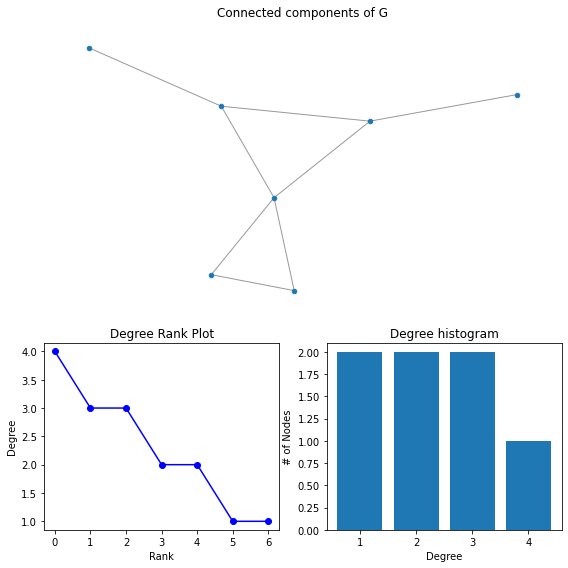

In [ ]:
# community detection
c = list(greedy_modularity_communities(G))

# how many communities we detected
community_count=len(c)
print('Communities found - %s ' % community_count); print()

# print communitied
for community in range(community_count):
  
  print('Community %d - %s' % (community, sorted(c[community])))

# demonstrate graph degrees
get_graph_degree(G)

### Texas Generative Wave 1

In [ ]:
# existing community topics
chk_topics = list(df_slice['source'].unique())

# purposed community topics
new_topics = get_related_topics(df_slice
                               , context = manual_context
                               , perspective = manual_state_trend) 
                                 
# new topic list
gen_topics = list(set(swap_tokens(chk_topics, new_topics)))


from the perspetive of NY resident, list single words diet topics linked to epilepsy 
['-ketogenic diet ']
['-ketogenic diet ']
[]
from the perspetive of NY resident, list single words activities topics linked to epilepsy 
['School, work. Activities: swimming']
['school', 'work. activities: swimming']
['school']
from the perspetive of NY resident, list single words holidays topics linked to epilepsy 
["Holidays: Christmas, New Year's Eve Topics Linked to Epilepsy : Seizures"]
['holidays: christmas', "new year's eve topics linked to epilepsy : seizures"]
['school']
from the perspetive of NY resident, list single words tv shows topics linked to epilepsy 
['"Seinfeld", "Friends","The Simpsons".']
['"seinfeld"', '"friends","the simpsons".']
['school', 'seinfeld']
from the perspetive of NY resident, list single words politics topics linked to epilepsy 
['1. Epilepsy and politics  2, Politics of epilepsy research 3) Rights for people with epileps 4). Access to health care 5), Stigma']
['1. e

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  if sys.path[0] == '':


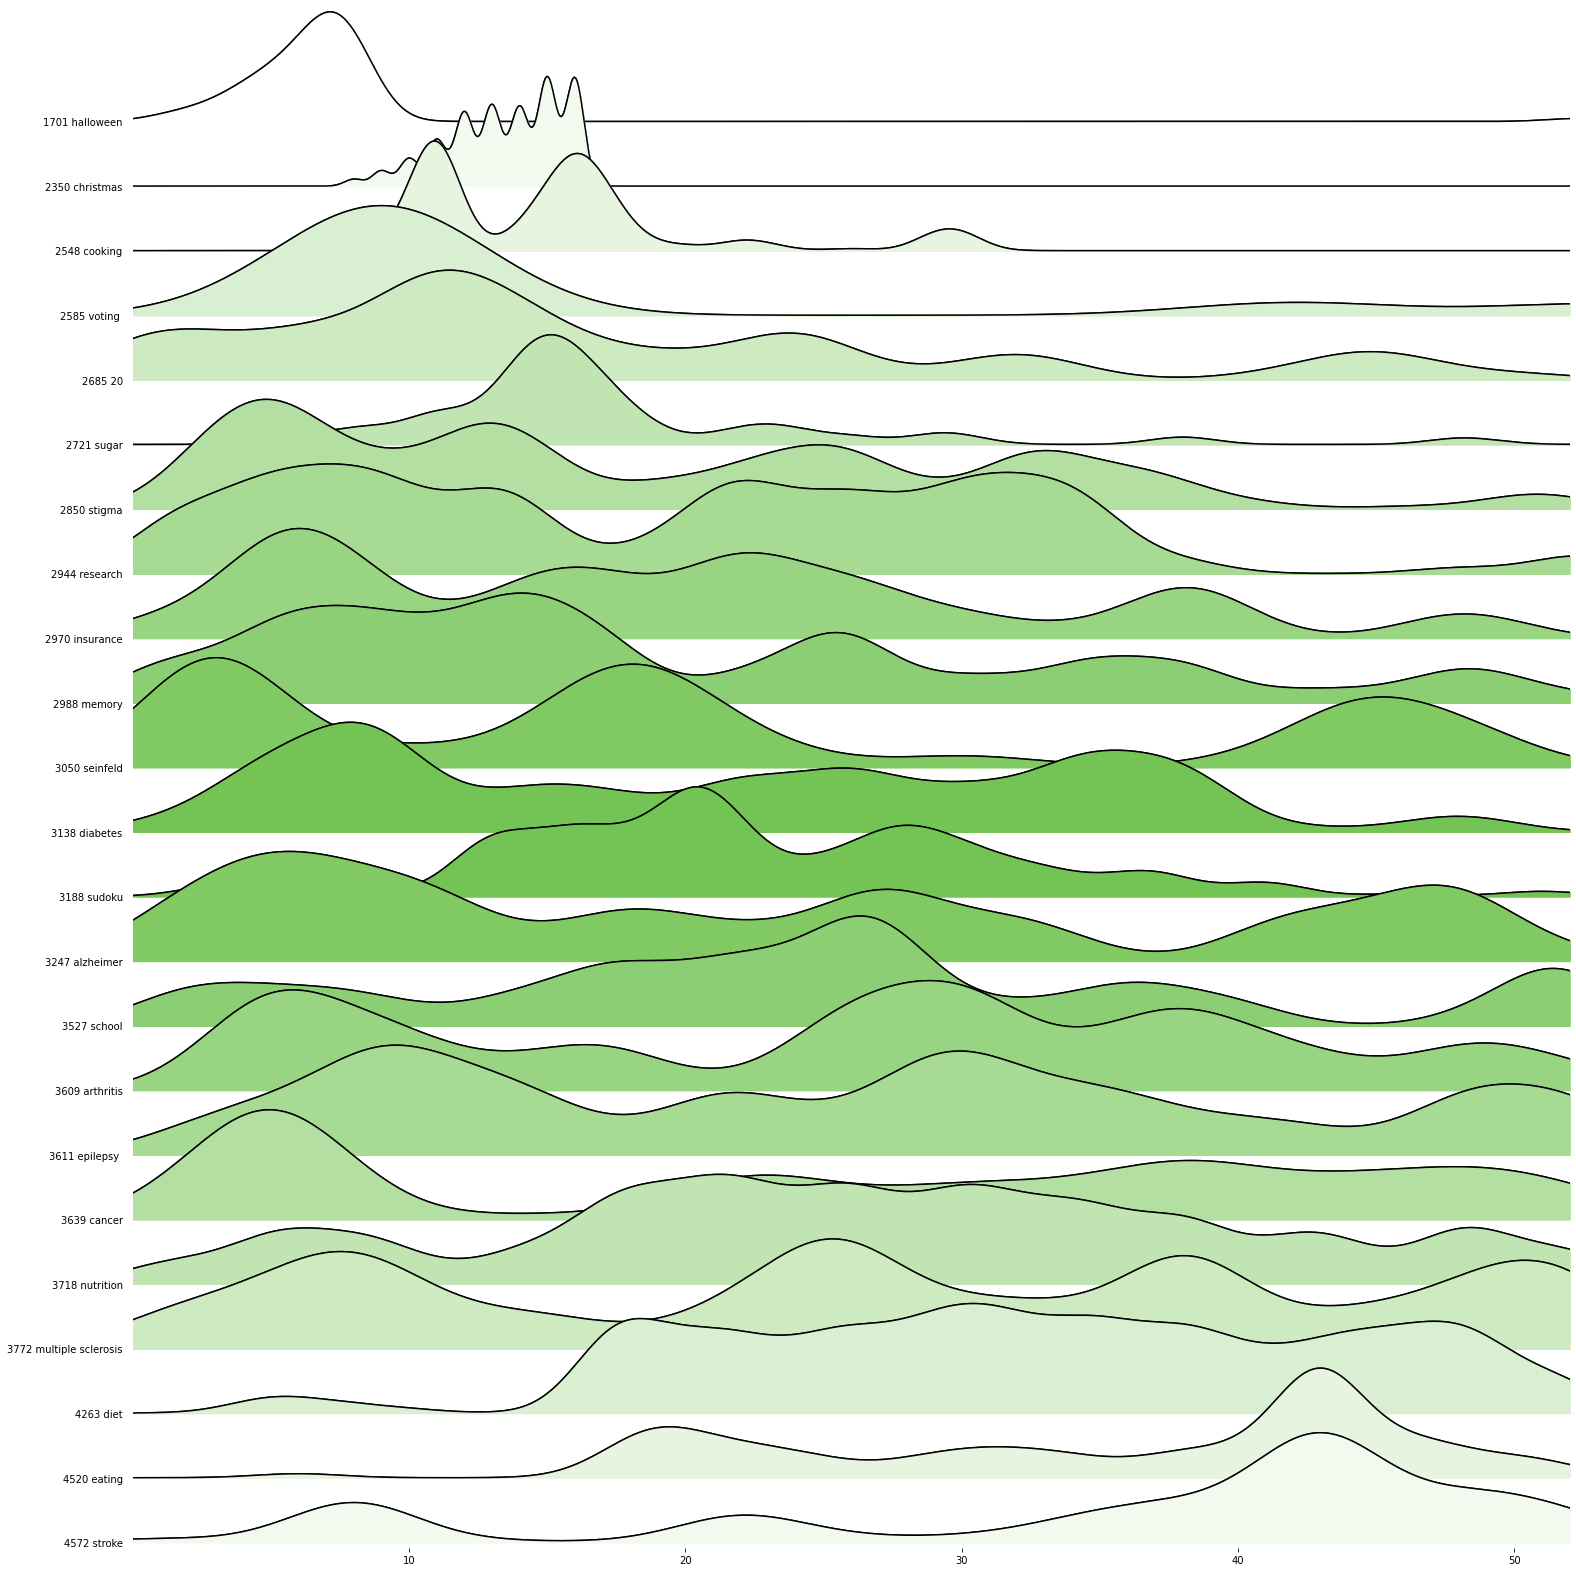

In [ ]:
# request features
df_features = get_trend_frame(gen_topics, '5', manual_state_trend)

# normalize feature space
df_features=(df_features-df_features.mean())/df_features.std()

# flatten feature space vertically
df_flat = stack_nodes_vertically(df_features)

# build node labels
df_flat = build_node_labels(df_flat)

# display ridgeplot of events
get_ridgeplot(df_flat)


   UNWIND $rows as row
   MATCH (p:generated_wave_1 {generated_wave_1:row.source}) 
 
   WITH row, p

    UNWIND row.target AS right_value
    MATCH (c:generated_wave_1 {generated_wave_1: right_value})
    MERGE (p)-[r:Minority]->(c)
    SET r.newyork = row.weight
    RETURN count(distinct p) as total
   

   UNWIND $rows as row
   MATCH (p:generated_wave_1 {generated_wave_1:row.source}) 
 
   WITH row, p

    UNWIND row.target AS right_value
    MATCH (c:generated_wave_1 {generated_wave_1: right_value})
    MERGE (p)-[r:Minority]->(c)
    SET r.newyork = row.weight
    RETURN count(distinct p) as total
   

   UNWIND $rows as row
   MATCH (p:generated_wave_1 {generated_wave_1:row.source}) 
 
   WITH row, p

    UNWIND row.target AS right_value
    MATCH (c:prompt {prompt: right_value})
    MERGE (p)-[r:Minority]->(c)
    SET r.newyork = row.weight
    RETURN count(distinct p) as total
   

   UNWIND $rows as row
   MATCH (p:generated_wave_1 {generated_wave_1:row.source}) 
 
   WITH r

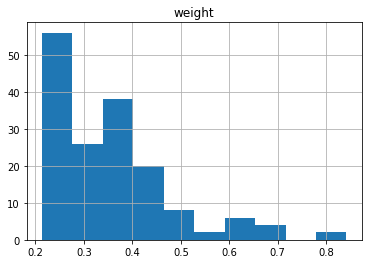

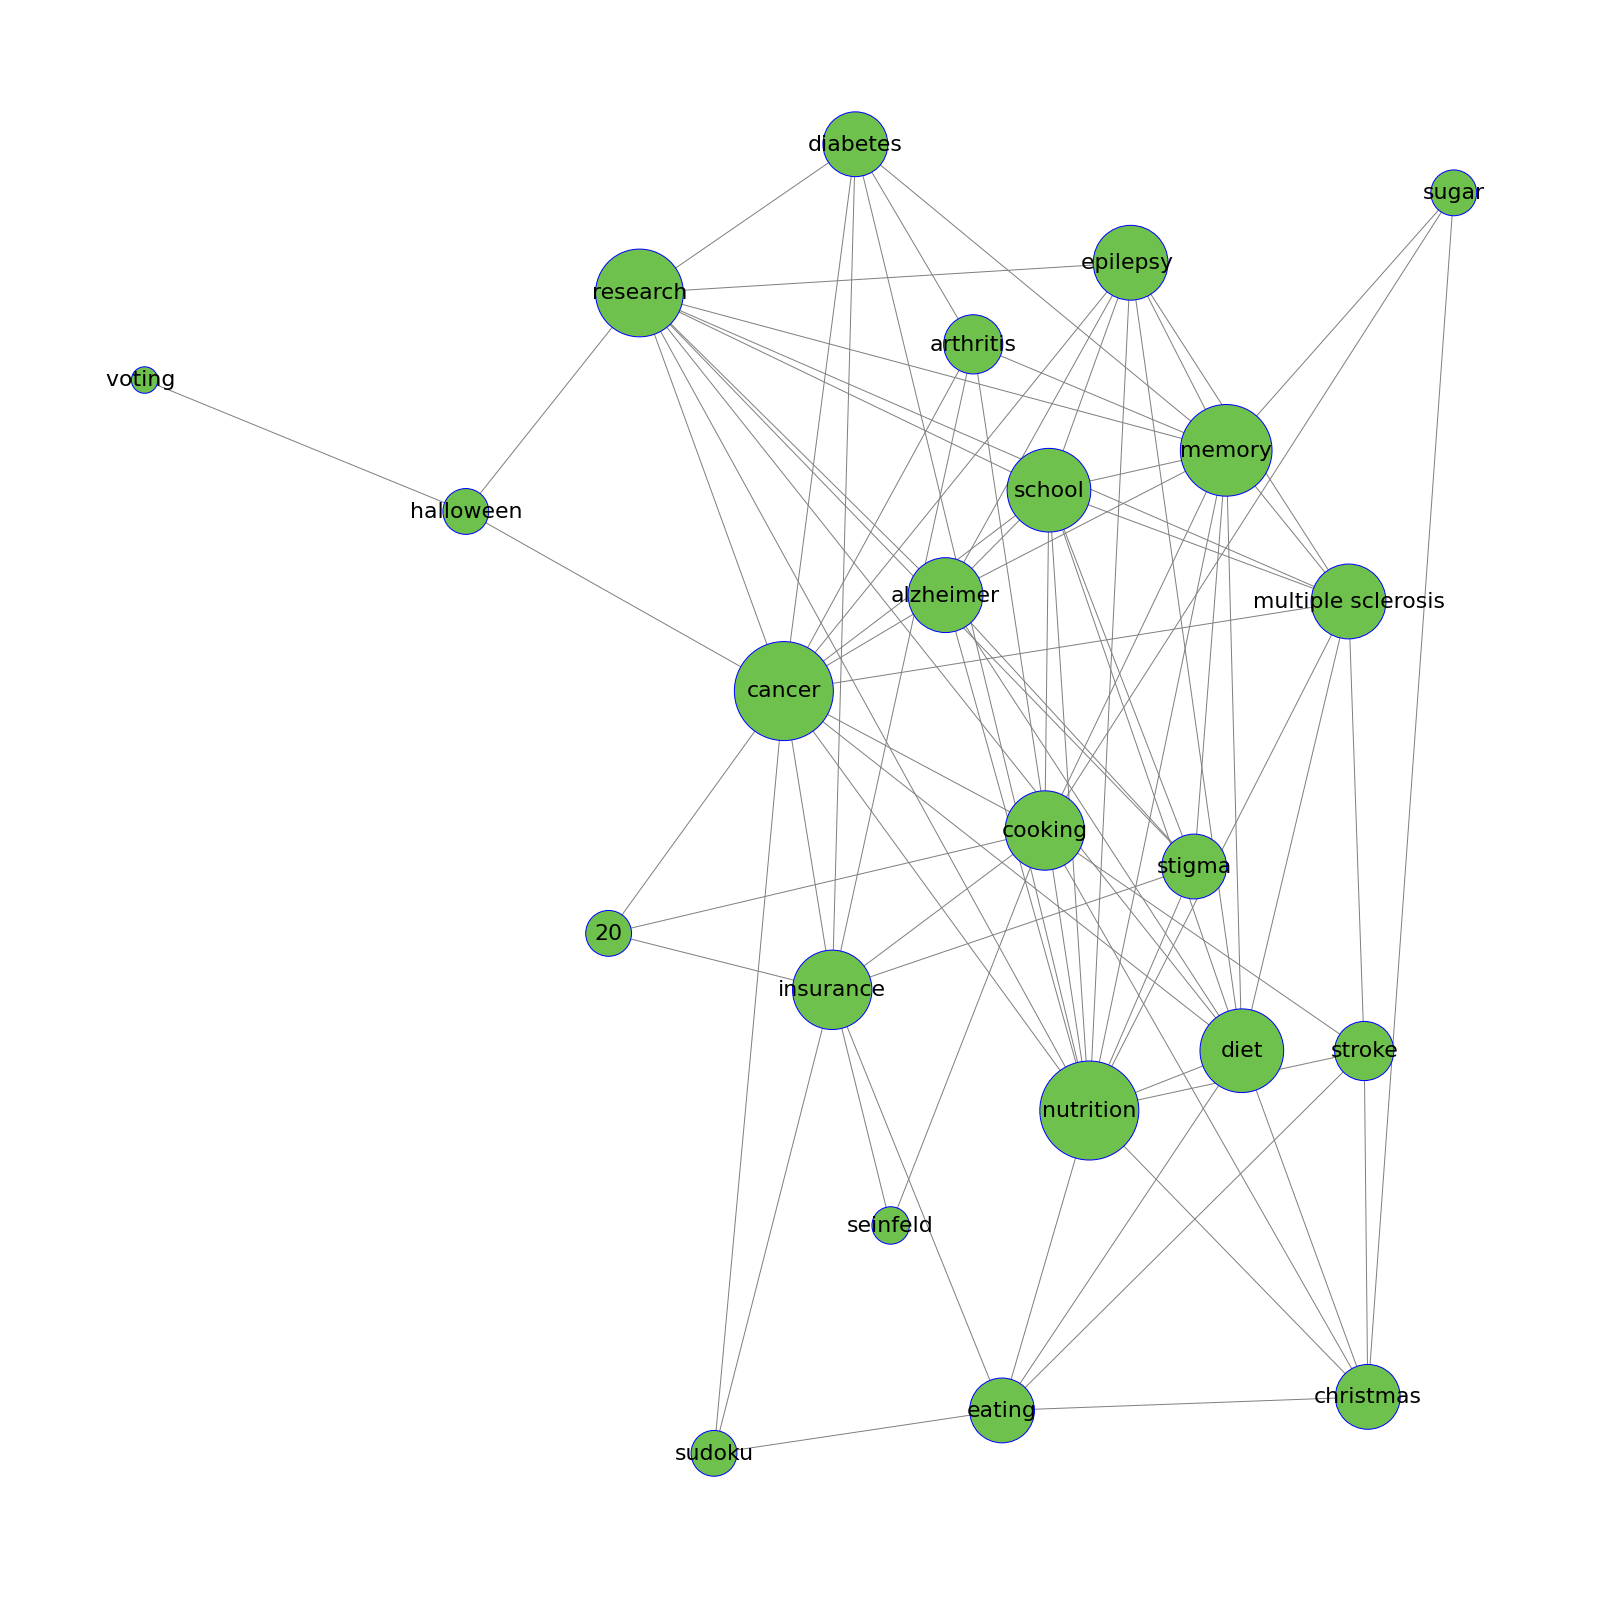

In [ ]:
edge_track = {}

# time-based pairwise similiarity weights
df_slice = get_pairwise_similarity(df_features, gen_topics, std_factor)

# reduce to relevant relationships
df_slice = df_slice[(df_slice['weight'] < max_similarity)]
df_slice = df_slice[df_slice['source'] != df_slice['target'] ]

# display flattened histogram
df_slice.hist()

# node label, entity type
entity_type = 'generated_wave_1'


# write nodes
write_node(df_slice[~df_slice['source'].isin(list(node_labels))], 'source', entity_type)

# record node label
for node in df_slice[~df_slice['source'].isin(list(node_labels))]['source']:
  node_labels[node] = entity_type

# record edges
df_slice_buffer = df_slice
df_slice_buffer['source_label'] = [ node_labels[i] for i in df_slice_buffer['source'] ]
df_slice_buffer['target_label'] = [ node_labels[i] for i in df_slice_buffer['target'] ]
df_distinct = df_slice.groupby(['source_label','target_label']).size().reset_index().rename(columns={0:'count'})

# for each distinct combination of labels / related nodes
for row in df_distinct.iterrows():
  df_slice_worker = df_slice_buffer
  distinct_combination_source_label = row[1][0]
  distinct_combination_target_label = row[1][1]

  # reduce relationships to involved vertex
  df_slice_worker = df_slice_worker.loc[df_slice_worker['source_label'] == distinct_combination_source_label]
  df_slice_worker = df_slice_worker.loc[df_slice_worker['target_label'] == distinct_combination_target_label]

  # filter on a single instance of a trelationship pattern
  df_slice_worker["rank"] = df_slice_worker.groupby("weight")["source"].rank("dense", ascending=False)
  df_slice_worker = df_slice_worker[df_slice_worker['rank']== 1]

  # create relationship
  add_edges(df_slice_worker, 'source', 'target'  # edges and directional weights
          , distinct_combination_source_label    # source label
          , distinct_combination_target_label )  # target label

# build graph
G = build_graph_network(df_slice)
Texas_genwave_1_G = G

In [ ]:
df_features

stroke    sudoku    memory      diet  alzheimer  diabetes  \
date                                                                      
2017-09-03 -0.492509 -0.844194  0.497481  0.390199   0.340896 -0.029785   
2017-09-10  0.198918 -1.202253  2.302295  0.019125   1.871983  0.273906   
2017-09-17 -0.077653 -0.008722 -0.465087 -0.129305   0.114068 -1.244550   
2017-09-24 -0.354223  0.349337  0.617802 -0.055090   1.758569  0.122060   
2017-10-01 -0.630794 -0.366781  0.738123  0.167554   1.021379  0.577597   
...              ...       ...       ...       ...        ...       ...   
2022-07-24  2.411484  1.542868 -1.307333 -1.019884  -0.453001  0.729443   
2022-07-31  1.996628  1.781575 -1.187012 -0.945670   1.304914  0.122060   
2022-08-07  1.305201  0.349337 -0.826050 -1.242529  -1.190191 -0.789013   
2022-08-14  0.475489  1.065456 -0.344766 -1.168314  -1.020070 -0.789013   
2022-08-21  0.613774  2.855752 -0.946370 -1.242529  -1.417019 -1.244550   

            multiple sclerosis  seinfeld     sugar  arthritis  ...   cooking  \
date                                                           ...             
2017-09-03            1.700506 -0.160210 -0.973552   0.231220  ... -0.088602   
2017-09-10            0.740603  0.360473 -0.815843  -0.341325  ... -0.480714   
2017-09-17            0.548622  2.616766 -0.973552  -2.488370  ... -0.676769   
2017-09-24            0.356641  2.443205 -0.815843  -2.058961  ... -0.676769   
2017-10-01           -0.315291  1.835741 -0.342715  -1.486416  ... -0.382686   
...                        ...       ...       ...        ...  ...       ...   
2022-07-24           -1.083214  0.967936  0.130414   1.233175  ... -0.382686   
2022-07-31           -0.411282  0.186912 -0.027296  -0.055052  ... -0.480714   
2022-08-07           -0.315291  0.186912 -0.658133  -0.913870  ... -0.578741   
2022-08-14           -0.507272  0.273692  0.130414   0.088084  ... -0.578741   
2022-08-21           -1.179205  0.534034 -0.342715   0.660629  ... -0.970853   

              cancer    school  christmas    eating  research  insurance  \
date                                                                       
2017-09-03 -0.476797  2.568995  -0.380831 -1.515864  1.001127   0.854569   
2017-09-10 -0.081997  1.287424  -0.380831 -0.836339  1.675073   0.447632   
2017-09-17  0.049603  0.646639  -0.380831 -0.666458  0.776478  -0.976651   
2017-09-24  0.181203  1.047130  -0.325944 -1.345983  0.926244  -0.976651   
2017-10-01  1.102403  0.967031  -0.271057 -0.496576  1.375541  -0.162775   
...              ...       ...        ...       ...       ...        ...   
2022-07-24 -0.608397 -1.115521  -0.435718  0.862475 -0.571414  -0.569713   
2022-07-31 -1.134797 -0.955325  -0.435718  0.013068 -0.571414   0.447632   
2022-08-07 -0.871597 -0.795128  -0.380831 -0.496576 -0.796063  -0.162775   
2022-08-14  0.444403 -0.314539  -0.435718  0.013068 -0.870946  -0.162775   
2022-08-21 -1.661197  0.406344  -0.435718 -0.326695 -0.796063  -1.383589   

            epilepsy    voting   nutrition  
date                                        
2017-09-03  -0.363292 -0.279286   1.183304  
2017-09-10  -0.072658 -0.056542   0.927206  
2017-09-17   0.363292 -0.279286   0.158912  
2017-09-24   0.363292 -0.279286   0.329644  
2017-10-01   0.072658 -0.279286   0.244278  
...               ...       ...        ...  
2022-07-24  -0.363292 -0.279286  -0.438650  
2022-07-31  -0.072658 -0.279286  -0.524016  
2022-08-07  -0.363292 -0.167914  -0.865480  
2022-08-14  -0.508609  0.054829  -0.780114  
2022-08-21  -0.217975  0.388944  -1.292310  

[260 rows x 23 columns]

Communities found - 3 

Community 0 - ['alzheimer', 'cancer', 'diet', 'epilepsy ', 'halloween', 'multiple sclerosis', 'research', 'school', 'stigma', 'voting ']
Community 1 - ['20', 'christmas', 'cooking', 'eating', 'insurance', 'seinfeld', 'stroke', 'sudoku', 'sugar']
Community 2 - ['arthritis', 'diabetes', 'memory', 'nutrition']


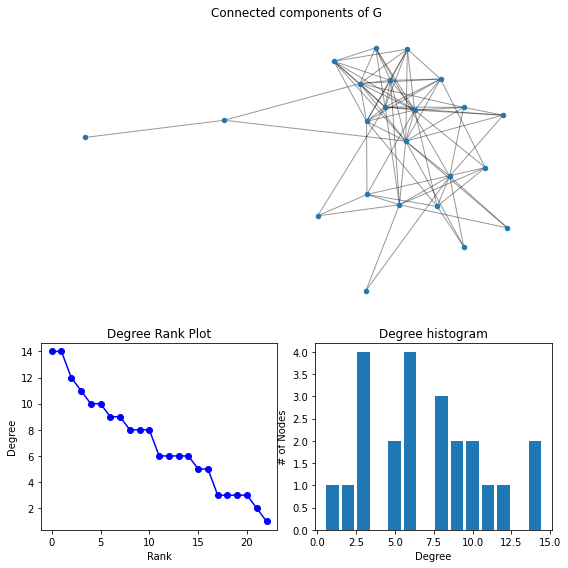

In [ ]:
# community detection
c = list(greedy_modularity_communities(G))

# how many communities we detected
community_count=len(c)
print('Communities found - %s ' % community_count); print()

# print communitied
for community in range(community_count):
  
  print('Community %d - %s' % (community, sorted(c[community])))

# demonstrate graph degrees
get_graph_degree(G)

In [ ]:
# TOP 10 Connective Nodes
sorted(G.degree, key=lambda x: x[1], reverse=True)[:10]

[('cancer', 14),
 ('nutrition', 14),
 ('memory', 12),
 ('research', 11),
 ('school', 10),
 ('diet', 10),
 ('cooking', 9),
 ('insurance', 9),
 ('epilepsy ', 8),
 ('alzheimer', 8)]

### Texas generative wave 2

In [ ]:
# existing community topics
chk_topics = list(df_slice['source'].unique())

# purposed community topics
# new_topics = get_related_topics(df_slice, 'Texas')
new_topics = get_related_topics(df_slice
                               , context = manual_context
                               , perspective = manual_state) 

# new topic list
gen_topics = list(set(swap_tokens(chk_topics, new_topics)))

from the perspetive of New York resident, list single words diet topics linked to school
['Health, Nutrition']
['health', 'nutrition']
['health', 'nutrition']
from the perspetive of New York resident, list single words activities topics linked to school
['Homework, teacher,, student desk']
['homework', 'teacher,', 'student desk']
['health', 'nutrition', 'homework', 'teacher']
from the perspetive of New York resident, list single words holidays topics linked to school
['Halloween, Thanksgiving']
['halloween', 'thanksgiving']
['health', 'nutrition', 'homework', 'teacher', 'halloween']
from the perspetive of New York resident, list single words tv shows topics linked to school
['-Homework \n\n-"The Office" (US) / "Derek"(Netflix original series about a retired nursing home worker, Derek Noakes played by Ricky Gervais.)']
['-homework ', '', '-"the office" (us) / "derek"(netflix original series about a retired nursing home worker', 'derek noakes played by ricky gervais.)']
['health', 'nutri


completed retrieval of batch 1 - 30 rows of 44
failed to add topic - hivaids 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  if sys.path[0] == '':


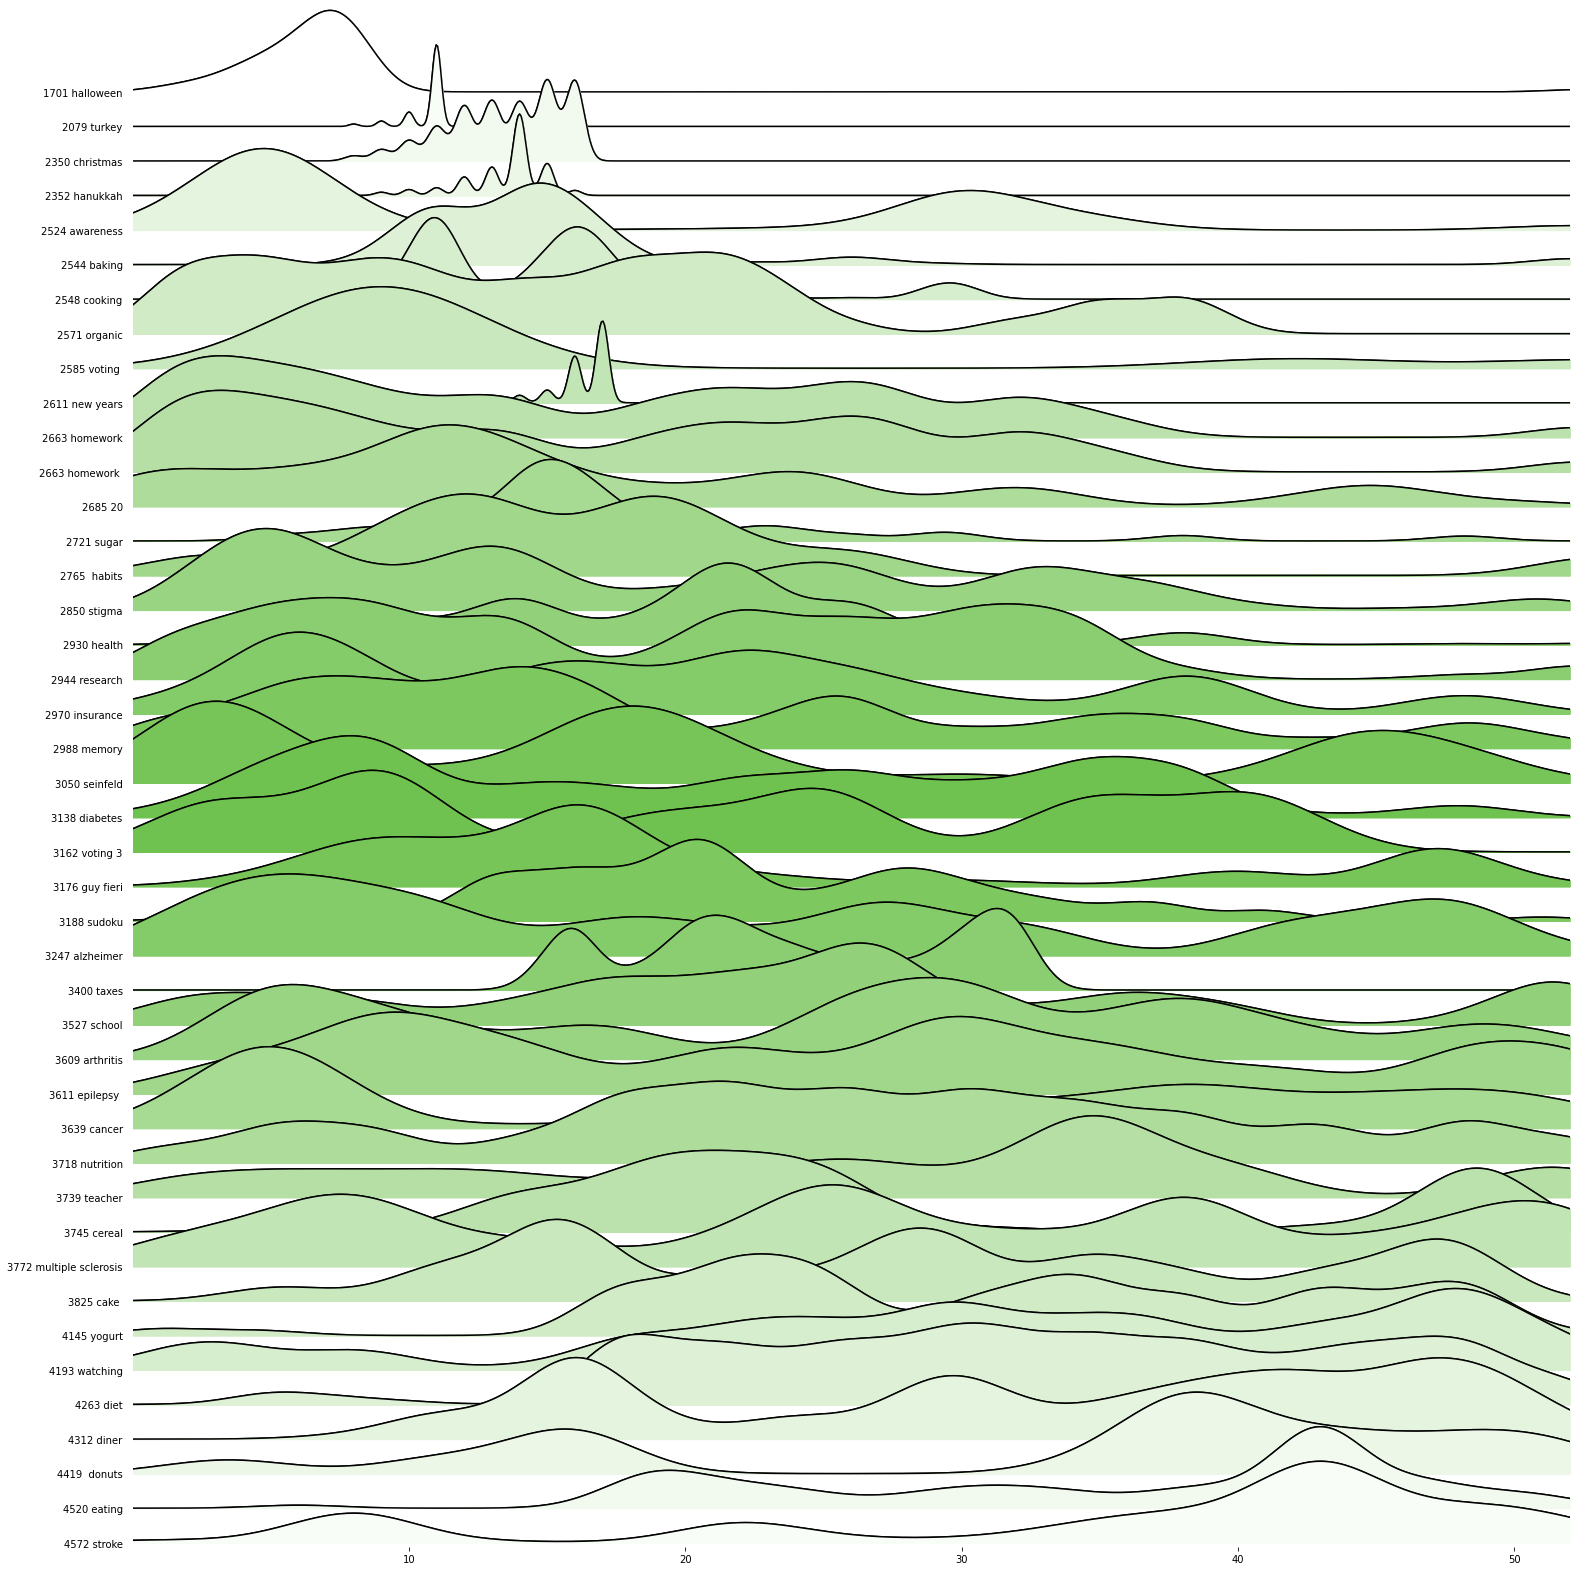

In [ ]:
# request features
df_features = get_trend_frame(gen_topics, '5', manual_state_trend)

# normalize feature space
df_features=(df_features-df_features.mean())/df_features.std()

# flatten feature space vertically
df_flat = stack_nodes_vertically(df_features)

# build node labels
df_flat = build_node_labels(df_flat)

# display ridgeplot of events
get_ridgeplot(df_flat)


   UNWIND $rows as row
   MATCH (p:generated_wave_1 {generated_wave_1:row.source}) 
 
   WITH row, p

    UNWIND row.target AS right_value
    MATCH (c:generated_wave_1 {generated_wave_1: right_value})
    MERGE (p)-[r:Minority]->(c)
    SET r.newyork = row.weight
    RETURN count(distinct p) as total
   

   UNWIND $rows as row
   MATCH (p:generated_wave_1 {generated_wave_1:row.source}) 
 
   WITH row, p

    UNWIND row.target AS right_value
    MATCH (c:generated_wave_1 {generated_wave_1: right_value})
    MERGE (p)-[r:Minority]->(c)
    SET r.newyork = row.weight
    RETURN count(distinct p) as total
   

   UNWIND $rows as row
   MATCH (p:generated_wave_1 {generated_wave_1:row.source}) 
 
   WITH row, p

    UNWIND row.target AS right_value
    MATCH (c:generated_wave_2 {generated_wave_2: right_value})
    MERGE (p)-[r:Minority]->(c)
    SET r.newyork = row.weight
    RETURN count(distinct p) as total
   

   UNWIND $rows as row
   MATCH (p:generated_wave_1 {generated_wave_1:row.s

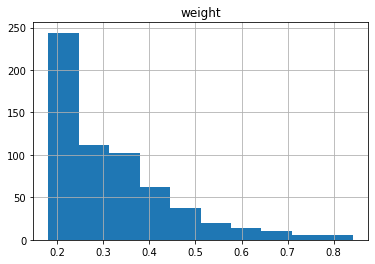

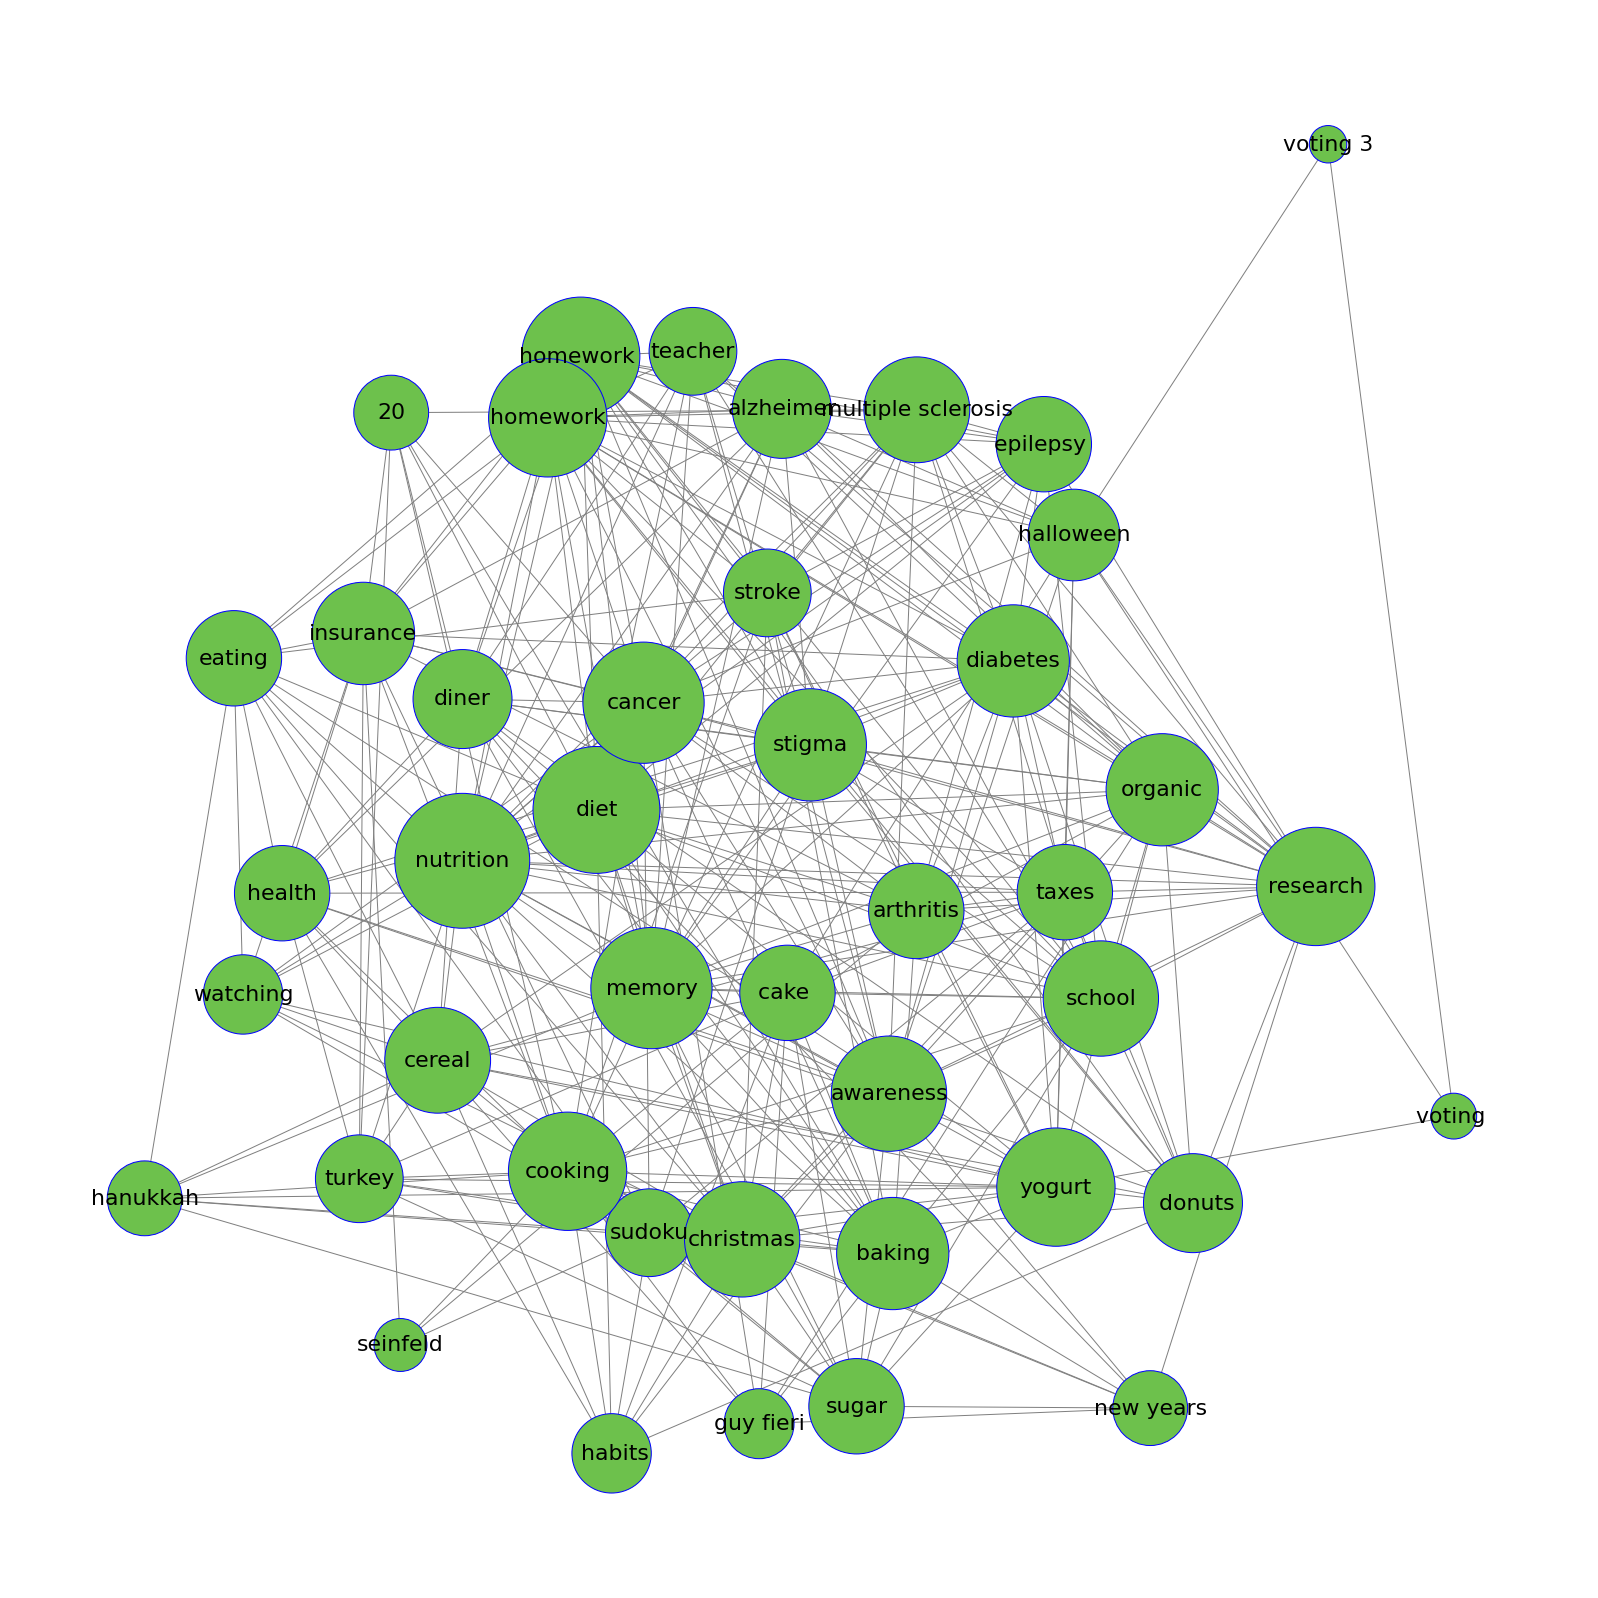

In [ ]:

edge_track = {}

# time-based pairwise similiarity weights
df_slice = get_pairwise_similarity(df_features, gen_topics, std_factor*2)

# reduce to relevant relationships
df_slice = df_slice[(df_slice['weight']< max_similarity )]
df_slice = df_slice[df_slice['source'] != df_slice['target'] ]

# display flattened histogram
df_slice.hist()


# node label, entity type
entity_type = 'generated_wave_2'

# write nodes
write_node(df_slice[~df_slice['source'].isin(list(node_labels))], 'source', entity_type)

# record node label
for node in df_slice[~df_slice['source'].isin(list(node_labels))]['source']:
  node_labels[node] = entity_type

# record edges
df_slice_buffer = df_slice
df_slice_buffer['source_label'] = [ node_labels[i] for i in df_slice_buffer['source'] ]
df_slice_buffer['target_label'] = [ node_labels[i] for i in df_slice_buffer['target'] ]
df_distinct = df_slice.groupby(['source_label','target_label']).size().reset_index().rename(columns={0:'count'})

# for each distinct combination of labels / related nodes
for row in df_distinct.iterrows():
  df_slice_worker = df_slice_buffer
  distinct_combination_source_label = row[1][0]
  distinct_combination_target_label = row[1][1]

  # reduce relationships to involved vertex
  df_slice_worker = df_slice_worker.loc[df_slice_worker['source_label'] == distinct_combination_source_label]
  df_slice_worker = df_slice_worker.loc[df_slice_worker['target_label'] == distinct_combination_target_label]

  # filter on a single instance of a trelationship pattern
  df_slice_worker["rank"] = df_slice_worker.groupby("weight")["source"].rank("dense", ascending=False)
  df_slice_worker = df_slice_worker[df_slice_worker['rank']== 1]

  # create relationship
  add_edges(df_slice_worker, 'source', 'target'  # edges and directional weights
          , distinct_combination_source_label    # source label
          , distinct_combination_target_label )  # target label
# build graph
G = build_graph_network(df_slice)
Texas_genwave_2_G = G

Communities found - 3 

Community 0 - ['alzheimer', 'arthritis', 'awareness', 'cancer', 'diabetes', 'diet', 'epilepsy ', 'homework', 'homework ', 'insurance', 'memory', 'multiple sclerosis', 'nutrition', 'organic', 'research', 'school', 'seinfeld', 'stigma', 'stroke', 'teacher']
Community 1 - [' donuts', ' habits', 'cake ', 'cereal', 'christmas', 'cooking', 'eating', 'halloween', 'hanukkah', 'health', 'sudoku', 'sugar', 'taxes', 'turkey', 'voting ', 'voting 3', 'watching', 'yogurt']
Community 2 - ['20', 'baking', 'diner', 'guy fieri', 'new years']


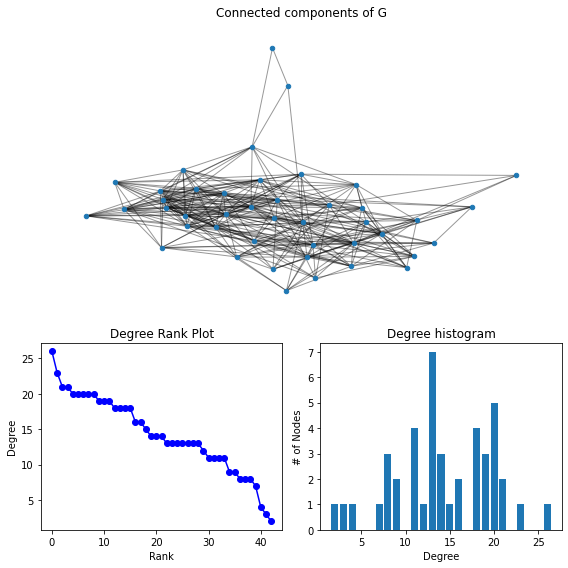

In [ ]:
# community detection
c = list(greedy_modularity_communities(G))

# how many communities we detected
community_count=len(c)
print('Communities found - %s ' % community_count); print()

# print communitied
for community in range(community_count):
  
  print('Community %d - %s' % (community, sorted(c[community])))

# demonstrate graph degrees
get_graph_degree(G)

In [ ]:
# TOP 10 Connective Nodes
sorted(G.degree, key=lambda x: x[1], reverse=True)[:10]

[('nutrition', 26),
 ('diet', 23),
 ('memory', 21),
 ('cancer', 21),
 ('yogurt', 20),
 ('homework ', 20),
 ('homework', 20),
 ('cooking', 20),
 ('research', 20),
 ('christmas', 19)]

['Florida-cereal', 'Florida-cake ', 'Florida-taxes', 'Florida-arthritis', 'Florida-yogurt', 'Florida-sugar', 'Florida-teacher', 'Florida-diet', 'Florida-homework ', 'Florida-eating', 'Florida-homework', 'Florida-stigma', 'Florida-sudoku', 'Florida-voting ', 'Florida-diabetes', 'Florida-multiple sclerosis', 'Florida-halloween', 'Florida-alzheimer', 'Florida-diner', 'Florida-epilepsy ', 'Florida-watching', 'Florida-nutrition', 'Florida-cooking', 'Florida-guy fieri', 'Florida- habits', 'Florida-turkey', 'Florida-stroke', 'Florida-memory', 'Florida-christmas', 'Florida-insurance', 'Florida-new years', 'Florida-research', 'Florida-cancer', 'Florida-baking', 'Florida-seinfeld', 'Florida-20', 'Florida-school', 'Florida-hanukkah', 'Florida- donuts', 'Florida-organic', 'Florida-awareness', 'Florida-voting 3', 'Florida-health', 'Texas-school', 'Texas-epilepsy ', 'Texas-seinfeld', 'Texas-cooking', 'Texas-memory', 'Texas-sugar', 'Texas-alzheimer', 'Texas-cancer', 'Texas-eating', 'Texas-nutrition',

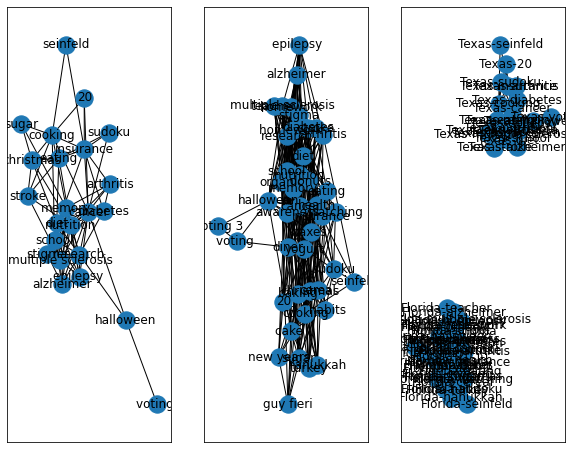

In [ ]:
# visualizations.draw_graph_overlap(G,orginal_G,edge_width=5,node_name_1="Type 2 diabetes",node_name_2="Type 2 diabetes",physics_enabled=False)
_,ax = plt.subplots(1,3, figsize=(10,8))
nx.draw_networkx(Texas_genwave_1_G, ax=ax[0])
nx.draw_networkx(Texas_genwave_2_G, ax=ax[1])
U = nx.union(Texas_genwave_2_G, Texas_genwave_1_G, rename=('Florida-','Texas-'))
#U = nx.union(G, orginal_G, rename=('T','T'))
#U = nx.disjoint_union(G, orginal_G)
nx.draw_networkx(U, ax=ax[2])
print(U.nodes())

# Graph ML Pipelines

In [ ]:
### Build experiment and projected graph

state_to_predice = 'Illinois'

# create node properties, based on relationship properties
create_node_property(state_to_predice, state_to_predice.lower())

# build maps to link node IDS to name and label
node_map, label_map = build_node_reference()

# build graph given new node property 
G = project_per_node_property(state_to_predice)

failure in graph initiation


In [ ]:
### Build ML pipeline

# create pipeline
pipe = create_pipeline("pipeline")

# build embedding of nodes
pipe = projection_embedding(pipe, 'embed')

# select features used in ML pipeline
pipe.selectFeatures(['embed', state_to_predice])

name                                                          pipeline
nodePropertySteps    [{'name': 'gds.fastRP.mutate', 'config': {'emb...
featureProperties                                    [embed, Illinois]
splitConfig                {'testFraction': 0.3, 'validationFolds': 3}
autoTuningConfig                                     {'maxTrials': 10}
parameterSpace          {'RandomForest': [], 'LogisticRegression': []}
Name: 0, dtype: object

In [ ]:
### add ML models and settings to pipeline

# logistic regression
pipe.addLogisticRegression( batchSize=10, maxEpochs=1000 )

# logistic regression
pipe.addLogisticRegression( batchSize=20, maxEpochs=100 )

# random forest
pipe.addRandomForest( maxDepth = 2 )

# random forest
pipe.addRandomForest( maxDepth = 3, numberOfDecisionTrees = 1000 )

# random forest
pipe.addRandomForest( maxDepth = 4, numberOfDecisionTrees = 5000 )

# random forest
pipe.addRandomForest( numberOfDecisionTrees = 10000)

name                                                          pipeline
nodePropertySteps    [{'name': 'gds.fastRP.mutate', 'config': {'emb...
featureProperties                                    [embed, Illinois]
splitConfig                {'testFraction': 0.3, 'validationFolds': 3}
autoTuningConfig                                     {'maxTrials': 10}
parameterSpace       {'RandomForest': [{'maxDepth': 2, 'minLeafSize...
Name: 0, dtype: object

In [ ]:
### Train pipeline and each model

# create training model
trained_pipe_model, res = create_model(G, 'my-model',state_to_predice)

# return model training stats
res['modelSelectionStats']

Node Classification Train Pipeline:   0%|          | 0/100 [00:00<?, ?%/s]

{'modelCandidates': [{'metrics': {'F1_WEIGHTED': {'validation': {'avg': 0.8665544699617094,
      'min': 0.864740561402314,
      'max': 0.8682561863558297},
     'train': {'avg': 0.9685945395127323,
      'min': 0.9645633915576741,
      'max': 0.972656244486178}},
    'ACCURACY': {'validation': {'avg': 0.8826742066666666,
      'min': 0.88135594,
      'max': 0.88333334},
     'train': {'avg': 0.99159664, 'min': 0.98319328, 'max': 1.0}}},
   'parameters': {'maxEpochs': 1000,
    'minEpochs': 1,
    'penalty': 0.0,
    'patience': 1,
    'methodName': 'LogisticRegression',
    'batchSize': 10,
    'tolerance': 0.001,
    'learningRate': 0.001}},
  {'metrics': {'F1_WEIGHTED': {'validation': {'avg': 0.8198198153145038,
      'min': 0.8198198153145038,
      'max': 0.8198198153145038},
     'train': {'avg': 0.817368934015751,
      'min': 0.8161434933294457,
      'max': 0.8198198153883614}},
    'ACCURACY': {'validation': {'avg': 0.8715630933333333,
      'min': 0.86666667,
      'max':

In [ ]:
### Review training performance

# Make sure our model performed well enough on the test set
metrics = trained_pipe_model.metrics()
print(metrics['F1_WEIGHTED']["test"])
print(metrics['ACCURACY']["test"])

# Predict on `H` and stream the results with a specific concurrency of 8
result = trained_pipe_model.predict_stream(G, concurrency=8)

0.8623188360806554
0.88311689


In [ ]:
# build model comparison dataset
gg = res['modelSelectionStats']
gg = gg['modelCandidates']

for candidate in gg:
  ggg = candidate['metrics']
  # ggg = ggg['ACCURACY']
  ggg = ggg['F1_WEIGHTED']
  ggg = ggg['validation']['avg']  

  fff = candidate['metrics']
  # ggg = ggg['ACCURACY']
  fff = fff['F1_WEIGHTED']
  fff = fff['train']['avg']  

  hhh = candidate['parameters']
  hhh = hhh['methodName']
  
  print('%s train avg - %f  val avg - %f' % (hhh, fff, ggg))

LogisticRegression train avg - 0.968595  val avg - 0.866554
LogisticRegression train avg - 0.817369  val avg - 0.819820
RandomForest train avg - 0.822588  val avg - 0.814940
RandomForest train avg - 0.835119  val avg - 0.819820
RandomForest train avg - 0.846099  val avg - 0.819820
RandomForest train avg - 0.877339  val avg - 0.824619


In [ ]:
res['modelSelectionStats']

{'modelCandidates': [{'metrics': {'F1_WEIGHTED': {'validation': {'avg': 0.8665544699617094,
      'min': 0.864740561402314,
      'max': 0.8682561863558297},
     'train': {'avg': 0.9685945395127323,
      'min': 0.9645633915576741,
      'max': 0.972656244486178}},
    'ACCURACY': {'validation': {'avg': 0.8826742066666666,
      'min': 0.88135594,
      'max': 0.88333334},
     'train': {'avg': 0.99159664, 'min': 0.98319328, 'max': 1.0}}},
   'parameters': {'maxEpochs': 1000,
    'minEpochs': 1,
    'penalty': 0.0,
    'patience': 1,
    'methodName': 'LogisticRegression',
    'batchSize': 10,
    'tolerance': 0.001,
    'learningRate': 0.001}},
  {'metrics': {'F1_WEIGHTED': {'validation': {'avg': 0.8198198153145038,
      'min': 0.8198198153145038,
      'max': 0.8198198153145038},
     'train': {'avg': 0.817368934015751,
      'min': 0.8161434933294457,
      'max': 0.8198198153883614}},
    'ACCURACY': {'validation': {'avg': 0.8715630933333333,
      'min': 0.86666667,
      'max':

In [ ]:
### Map node IDS to node names and labels

# for each node id
result['nodeName'] = [node_map[node][0] for node in result['nodeId']]

# output predicted class/node property
result.sort_values('predictedClass',ascending=False)

nodeId  predictedClass predictedProbabilities   nodeName
159     159              19                   None    weather
147     147              19                   None    walking
150     150              19                   None     easter
151     151              19                   None    fatigue
152     152              19                   None      about
..      ...             ...                    ...        ...
88       88               0                   None  nutrition
89       89               0                   None      pasta
90       90               0                   None      bread
91       91               0                   None    walking
255     255               0                   None   voting 3

[256 rows x 4 columns]

In [ ]:
### Shortest path between two nodes

shortest_path('nutrition', 'obesity')
shortest_path('smoking', 'obesity')

nutrition
income
obesity
smoking
cooking
obesity


In [ ]:
### Inter-node statistics

graph_stats('smoking', 'obesity')

adamicAdar link prediction - 0.447070
total neighbors - 29.000000
common neighbors - 2.000000
number of nodes in same commnuity - 0.000000
number of nodes in same commnuity - 0.000000


In [ ]:
### Node similarity

# graph data science node similarity
t_res = gds.nodeSimilarity.stream(G
                                 , nodeLabels=['generated_wave_1'
                                              ,'prompt'
                                              ,'generated_wave_2'])
temp_res = t_res.copy()

# mao node ids to name
temp_res['node1'] = [ node_map[i][0] for i in temp_res['node1'] ]
temp_res['node2'] = [ node_map[i][0] for i in temp_res['node2'] ]


# drop duplicate reporting of node similarity
print(len(temp_res))

# for each node combination
for row_idx in range(0, len(temp_res)):

  # node combination
  first_copy_node1 = temp_res['node1'][row_idx]
  first_copy_node2 = temp_res['node2'][row_idx]

  for row_idx2 in range(0, len(temp_res)):

2503
dieting sports
dieting weather
dieting texas
dieting football 
dieting salmon
dieting golfing 
dieting turkey
dieting diet
dieting resident
dieting holidays
potatoes hospital
potatoes carbs
potatoes bread 
potatoes joints 
potatoes pollution
potatoes holidays
potatoes property
potatoes painful
potatoes fruit
potatoes pain 
state painful
state swimming 
state swimming
state salt 
state abortion
state fruit 
state beaches
state carbs
state golfing 
state pain 
joints  income
joints  property
joints  potatoes
joints  diabetes 
joints  cancer 
joints  exercise
joints  joints
joints  doctor
joints   pain
joints  policy
rights movement
rights fruit 
rights exercise
rights potatoes
rights pain 
rights joints 
rights biking
rights taxes
rights income
rights sodium
sunbathe abortion
sunbathe selma
sunbathe elbows
sunbathe greens 
sunbathe sclerosis
sunbathe drinking
sunbathe beaches
sunbathe bike ride
sunbathe driving
sunbathe watch tv 
cooking exercise
cooking carbs
cooking cooking 
cooki